# Проект - промышленность

# Описание проекта
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Требуется построить модель, которая предскажет температуру стали.

## Описание этапа обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

# Цель проекта

Построить модель, которая предскажет температуру стали

# Задача проекта
После уточнения задания стало ясно, что целевым признаком является последнее измерение температуры для каждой партии. Целевая метрика - MAE

# Содержание проекта

- [1 Знакомство с данными](#step_1):  

-- Открытие файлов и первый взгляд на данные  
-- Более продробное знакомство с данными  
-- Вывод по знакомству с данными

- [2 Подготовка подробного плана работы](#step_2)

- [3 Предобработка данных](#step_3)

- [4 Подготовка признаков](#step_4)

- [5 Подбор оптимальной модели и гиперпараметров для неё](#step_5)

- [6 Тестирование модели](#step_6)

- [7 Вывод](#step_7)

<a id='step_1'></a>
# Знакомство с данными

## Открытие файлов и первый взгляд на данные

In [1]:
# сначала установлю catboost
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# ячейка импорта (сюда складировал, то с чем пытался работать, в т.ч. то чего нет на данном этапе, но планирую применить 
# при работе с моделями)

import numpy as np
import lightgbm as lgb           # импорт LightGBM
import matplotlib.pyplot as plt  

import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor               # импорт CatBoostRegressor
from lightgbm import LGBMRegressor                   # импорт LGBMRegressor
from sklearn.cluster import KMeans                   # импорт K-means
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor  # модель случанйого леса 
from sklearn.feature_selection import VarianceThreshold  # для фильтрации признаков с низкой вариативностью
from sklearn.linear_model import LinearRegression   # модель линейной регрессии
from sklearn.metrics import make_scorer              # импорт make_scorer
from sklearn.metrics import mean_absolute_error      #импорт функции для расчета целевой метрики 
from sklearn.model_selection import cross_val_score  # для кросс-валидации
from sklearn.model_selection import GridSearchCV     # для подобора гиперпараметров
from sklearn.model_selection import RandomizedSearchCV # для подобора гиперпараметров
from sklearn.model_selection import train_test_split  # для разбиения на выборки
from sklearn.preprocessing import StandardScaler     # для масштабирования
from sklearn.tree import DecisionTreeRegressor      # модель решающего дерева
random_state=250722

In [4]:
# открытие файла (чтобы файлы открывались и в тренажере и у меня на компьютере прописал альтернативный путь)

data_path = 'C:/Users/v.kozlovskiy/Desktop/_YP_final_project/final_steel/final_steel'
data_path2 = '/datasets/final_steel/'

try:

    data_arc = pd.read_csv(data_path + '/data_arc.csv')
    data_bulk = pd.read_csv(data_path + '/data_bulk.csv')
    data_bulk_time = pd.read_csv(data_path + '/data_bulk_time.csv')
    data_gas = pd.read_csv(data_path + '/data_gas.csv')
    data_temp = pd.read_csv(data_path + '/data_temp.csv')
    data_wire = pd.read_csv(data_path + '/data_wire.csv')
    data_wire_time = pd.read_csv(data_path + '/data_wire_time.csv')

except:
    
    data_arc = pd.read_csv(data_path2 + '/data_arc.csv')
    data_bulk = pd.read_csv(data_path2 + '/data_bulk.csv')
    data_bulk_time = pd.read_csv(data_path2 + '/data_bulk_time.csv')
    data_gas = pd.read_csv(data_path2 + '/data_gas.csv')
    data_temp = pd.read_csv(data_path2 + '/data_temp.csv')
    data_wire = pd.read_csv(data_path2 + '/data_wire.csv')
    data_wire_time = pd.read_csv(data_path2 + '/data_wire_time.csv')

In [5]:
# сделаю список из всех датасетов для общего взгляда (много применять его не планирую)
datas = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]

In [6]:
# сразу посмотрю на все датафреймы с помощью info()
display([i.info() for i in datas])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-n

[None, None, None, None, None, None, None]

- Видно, что датасеты разные по размеру максимальный - data_arc (14876) значений, там пропусков нет

- в data_bulc и data_bulk_time 3129 значений, столбцы назваются одинаково и число пропусков в столбцах одинаковое (по крайней мере так видно из info() )

- в data_gas 3239 знначений (без пропусков) и кроме значени газ, есть только значение партии (дат нет)

- в data_temp 15907 значений, достаточно много пропусков в столбце температура (примерно 3 тысячи)

- в data_wire и data_wire_temp ситуация сходная с data_bulk - одинаковое число значений (3081), одинаковые названия столбцов и сходное пропуски

- во всех датасетах есть столбец key

- все ключи в формате int, остальные данные во float, похоже, что все даты в object

In [7]:
# и проверю наличие дубликатов
display([i.duplicated().sum() for i in datas]) 

[0, 0, 0, 0, 0, 0, 0]

Дубликатов нет, дальше хочу посмотреть на каждый датасет подробнее

## Более продробное знакомство с данными

### Данные по нагреву (data_arc)

In [8]:
# посмотрю на данные
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


Видно (то о чем говорилось в задании), что нескольким значениям key соответствуют несколько итераций нагрева и измерений мощностей. Похоже, что данные идут по порядку (но на 100% в этом быть уверенным нельзя + об этом упоминалось на консультации - так что имеет смысл их отсортировать - сначала по key, потом по одной из дат - думаю, что одной хватит). Также хочу открыть значения с датами в формате дат (думаю, что это будет нелишним) и перевести названия столбцов в змеиный регистр

In [9]:
try:
    data_arc = pd.read_csv(data_path + '/data_arc.csv', parse_dates=[1,2])
except:
    data_arc = pd.read_csv(data_path2 + '/data_arc.csv', parse_dates=[1,2])    

In [10]:
data_arc.columns = ['key', 'heating_start', 'heating_end', 'active_power', 'reactive_power']

In [11]:
# посмотрю с помощью describe()
data_arc.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [12]:
data_arc.describe(include=['datetime64'])

C:\Users\v.kozlovskiy\AppData\Local\Temp\ipykernel_22584\1043033300.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data_arc.describe(include=['datetime64'])
C:\Users\v.kozlovskiy\AppData\Local\Temp\ipykernel_22584\1043033300.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data_arc.describe(include=['datetime64'])


,heating_start,heating_end
count,14876,14876
unique,14875,14876
top,2019-06-10 22:02:03,2019-05-03 11:06:02
freq,2,1
first,2019-05-03 11:02:14,2019-05-03 11:06:02
last,2019-09-01 04:34:47,2019-09-01 04:36:08


буду смотреть дальше пока точно видно очень странное значение в reactive_power (-700), c датами все выглядит нормально, хотя heating_start в одном месте имеет два значений (10 июня) - при этом уже было видно, что дубликатов нет

In [13]:
# на всякий случай отсортирую
data_arc = data_arc.sort_values(by=['key', 'heating_start'])

In [14]:
data_arc

,key,heating_start,heating_end,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


После сортировки выглядит также, но может быть в глубине датасета что-то улучшится

после сортировки точнее видно 3241 значение партии (хотя не факт, что они непрырывны)

Text(0.5, 1.0, 'reactive_power')

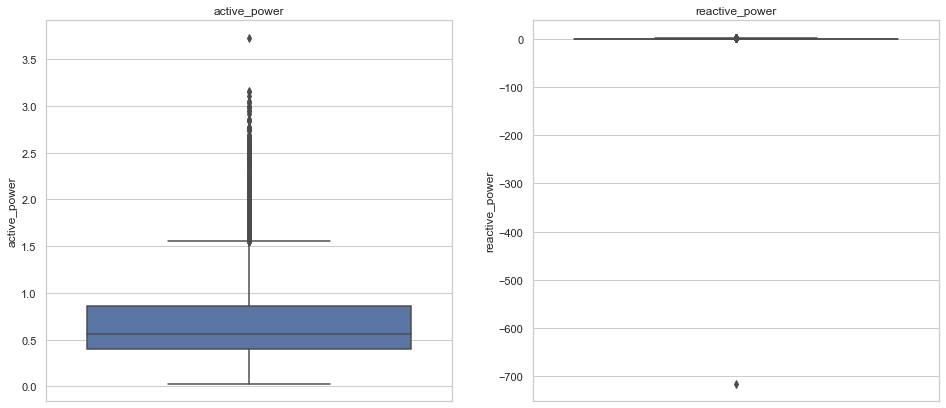

In [15]:
# посмотрю на диаграму размаха 
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)

plt.subplot(1, 2, 1)
sns.boxplot(y=data_arc['active_power'])
plt.title('active_power')

plt.subplot(1, 2, 2)
sns.boxplot(y=data_arc['reactive_power'])
plt.title('reactive_power')

Теперь хорошо видно, что reactive_power есть аномалия, разговор об этом был и на консультации - выходы за пределы усов в active_power не кажутся сильными (хотя на этапе предобработки хочу посмотреть на них подробнее)

<AxesSubplot:xlabel='heating_end', ylabel='active_power'>

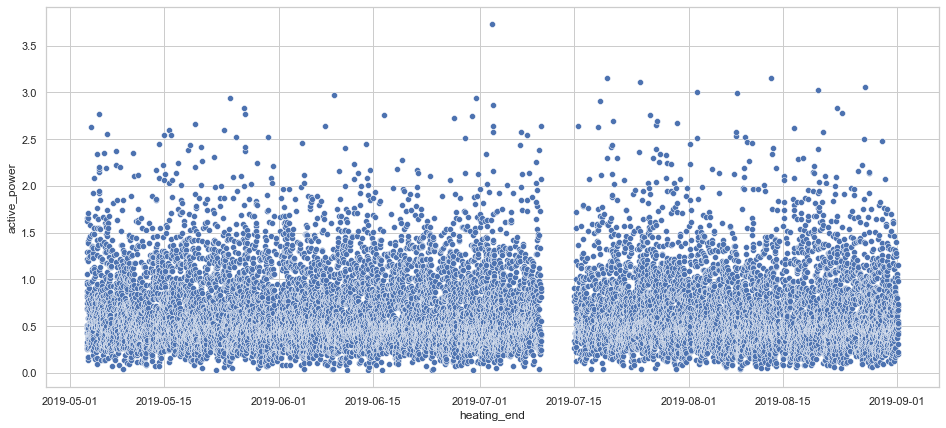

In [16]:
# посмотрю на диаграммы рассеяния для active_power
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
sns.scatterplot(data=data_arc, x='heating_end', y='active_power')

В общем выглядит нормально - явно виден провал где-то между 10 и 15 июля - данных нет (при этом пропусков в датасете нет)

<AxesSubplot:xlabel='heating_start', ylabel='reactive_power'>

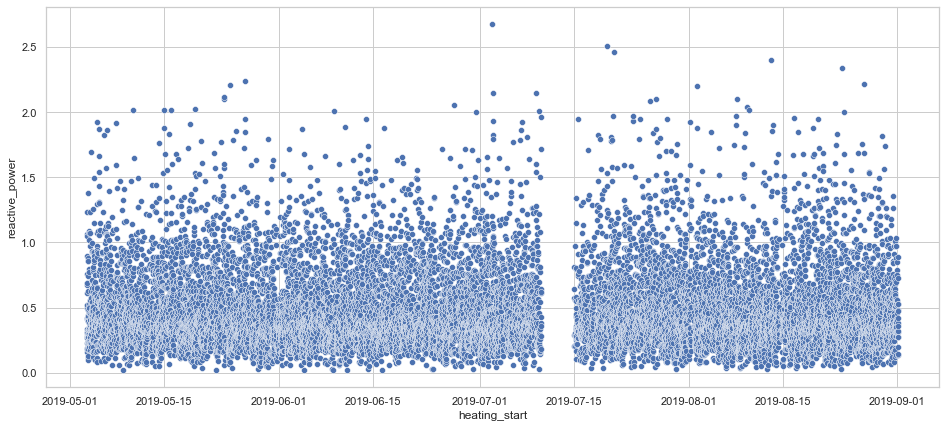

In [17]:
# для reactive_power аномальное значение уберу
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
sns.scatterplot(data=data_arc.query('reactive_power > 0'), x='heating_start', y='reactive_power')

Для reactive_power виден такой же провал (здесь по оси х взял heating_start), посмотрю на боксплот без выброса

Text(0.5, 1.0, 'reactive_power')

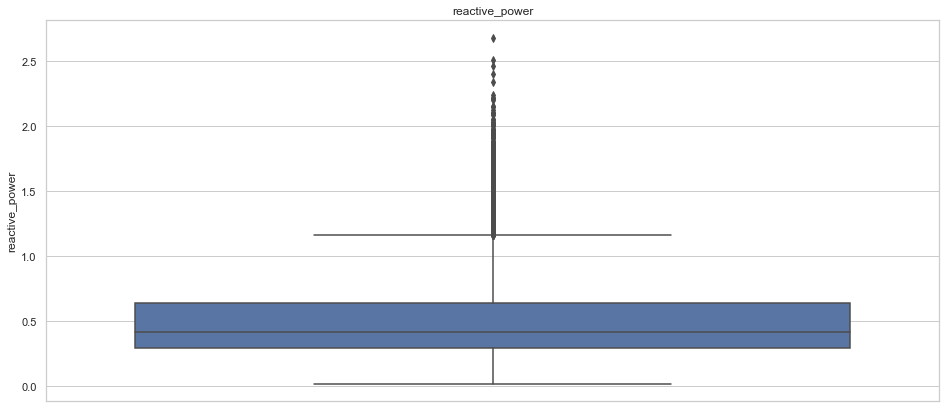

In [18]:
plt.figure(figsize=(16, 7))
sns.boxplot(y=data_arc.query('reactive_power > 0')['reactive_power'])
plt.title('reactive_power')

Так ситуация очень похожа на ситуацию с active_power

In [19]:
# посмотрю на корреляции
data_arc.corr()

,key,active_power,reactive_power
key,1.000000,-0.021382,-0.004396
active_power,-0.021382,1.000000,0.054437
reactive_power,-0.004396,0.054437,1.000000


корреляции не видно

### Данные по сыпучим веществам (data_bulk)

In [20]:
# посмотрю на данные
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [21]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [22]:
# в отдельных случаях корреляции заметны (в т.ч. сильные), но их не очень много
data_bulk.corr()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,1.000000,-0.192066,-0.038643,-0.080335,-0.101955,-0.018074,-0.063539,-0.049425,NaN,0.262741,0.288135,-0.156748,-0.030981,0.050304,-0.149840,-0.169873
Bulk 1,-0.192066,1.000000,-0.073762,0.016731,-0.040465,-0.368980,0.141745,-0.086223,NaN,NaN,-0.278055,0.461895,0.370501,1.000000,0.409188,-0.119006
Bulk 2,-0.038643,-0.073762,1.000000,NaN,0.393882,0.070350,NaN,-0.010043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 3,-0.080335,0.016731,NaN,1.000000,-0.260918,0.144410,0.253080,NaN,NaN,0.072850,-0.244532,0.137997,0.011648,-0.582598,0.026257,-0.023689
Bulk 4,-0.101955,-0.040465,0.393882,-0.260918,1.000000,-0.077214,-0.333841,0.324940,NaN,0.766565,-0.516399,NaN,0.051112,-0.311659,0.022925,0.041190
Bulk 5,-0.018074,-0.368980,0.070350,0.144410,-0.077214,1.000000,-0.511112,0.304476,NaN,NaN,NaN,NaN,0.007650,NaN,-0.256040,-0.248216
Bulk 6,-0.063539,0.141745,NaN,0.253080,-0.333841,-0.511112,1.000000,NaN,NaN,NaN,NaN,-0.104251,-0.079822,0.844690,0.154429,-0.038363
Bulk 7,-0.049425,-0.086223,-0.010043,NaN,0.324940,0.304476,NaN,1.000000,NaN,NaN,NaN,NaN,0.538671,NaN,1.000000,NaN
Bulk 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 9,0.262741,NaN,NaN,0.072850,0.766565,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.946954,NaN,-0.479974,NaN


видно, что разные bulk имеют разное число значений, особых аномалий мне кажется нет (стандартное отклонение не особо отличается от среднего, медиана тоже близко к среднему), заметно, что в некоторых bulk значений совсем мало (напрмер одно) - видимо (и об этом шла речь на консультации их можно будет удалить. Границу, по котрой удалять выберу чуть позже

In [23]:
# посмотрю на data_bulk_time
data_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


In [24]:
# открою даты в формате дат (возможно это лучше сделать каким-то более разумным способом, например в цикле перевести в datetime, но мне так показалось сейчас быстрее)

try:
    data_bulk_time = pd.read_csv(data_path + '/data_bulk_time.csv', parse_dates=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

except:
    data_bulk_time = pd.read_csv(data_path2 + '/data_bulk_time.csv', parse_dates=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

In [25]:
data_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaT,NaT,2019-08-31 22:51:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 22:46:52,NaT,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaT,NaT,2019-08-31 23:39:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 23:33:09,NaT,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:51:58,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:39:41,NaT,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaT,NaT,NaT,NaT,NaT,2019-09-01 03:12:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-01 02:41:27,2019-09-01 02:41:27


In [26]:
data_bulk_time.describe(include=['datetime64'])

C:\Users\v.kozlovskiy\AppData\Local\Temp\ipykernel_22584\2060406330.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data_bulk_time.describe(include=['datetime64'])
C:\Users\v.kozlovskiy\AppData\Local\Temp\ipykernel_22584\2060406330.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data_bulk_time.describe(include=['datetime64'])
C:\Users\v.kozlovskiy\AppData\Local\Temp\ipykernel_22584\2060406330.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=Tr

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
unique,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
top,2019-05-03 17:50:19,2019-05-07 08:36:19,2019-05-03 20:13:36,2019-05-03 11:21:30,2019-05-07 08:36:19,2019-05-03 18:52:57,2019-05-07 11:37:42,2019-07-05 17:46:11,2019-05-14 00:04:56,2019-05-06 01:36:24,2019-05-05 16:45:05,2019-05-03 11:03:52,2019-05-05 00:39:35,2019-05-03 11:03:52,2019-05-03 11:03:52
freq,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
first,2019-05-03 17:50:19,2019-05-07 08:36:19,2019-05-03 20:13:36,2019-05-03 11:21:30,2019-05-07 08:36:19,2019-05-03 18:52:57,2019-05-07 11:37:42,2019-07-05 17:46:11,2019-05-14 00:04:56,2019-05-06 01:36:24,2019-05-05 16:45:05,2019-05-03 11:03:52,2019-05-05 00:39:35,2019-05-03 11:03:52,2019-05-03 11:03:52
last,2019-08-30 23:01:32,2019-08-08 17:34:38,2019-08-31 23:39:11,2019-08-30 17:36:30,2019-08-28 09:01:08,2019-09-01 03:12:40,2019-08-31 07:22:25,2019-07-05 17:46:11,2019-08-11 15:09:33,2019-08-30 01:30:42,2019-08-31 16:00:49,2019-09-01 01:39:41,2019-08-26 20:31:16,2019-09-01 04:05:34,2019-09-01 04:05:34


Данные по времени для bulk выглядят естественно

### Данные по газу (data_gas)

In [27]:
data_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [28]:
# переведу в змеиный регистр
data_gas.columns = ['key', 'gas']

In [29]:
data_gas.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<AxesSubplot:ylabel='gas'>

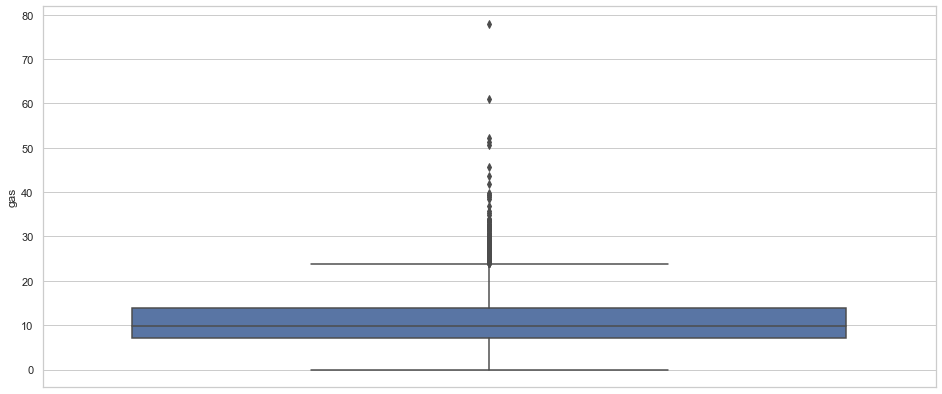

In [30]:
plt.figure(figsize=(16, 7))
sns.boxplot(y=data_gas['gas'])

в общем данные выглядт нормально, хотя выбросы заметны (не очень сильные) про них тоже говорили на консультации - при предобработке посмотрю на них подробнее

### Данные по температуре (data_temp)

In [31]:
# посмотрю на данные
data_temp.head(20)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


Как и в случае с data_arc видно последовательное расоложение данных (сначала по партии потом, по времени), но все равно хочу их отсортировать. как и в предыдущих датасетах переведу столбцы в змеиный регистр и открою даты, как даты

In [32]:
try:
    data_temp = pd.read_csv(data_path + '/data_temp.csv', parse_dates=[1])
except:
    data_temp = pd.read_csv(data_path2 + '/data_temp.csv', parse_dates=[1])

In [33]:
data_temp.columns = ['key', 'measure_time', 'temperature']

In [34]:
data_temp = data_temp.sort_values(by=['key', 'measure_time'])

In [35]:
data_temp.describe()

,key,temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [36]:
data_temp.describe(include=['datetime64'])

C:\Users\v.kozlovskiy\AppData\Local\Temp\ipykernel_22584\3513429706.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data_temp.describe(include=['datetime64'])


,measure_time
count,15907
unique,15907
top,2019-05-03 11:16:18
freq,1
first,2019-05-03 11:16:18
last,2019-09-01 04:38:08


In [37]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   measure_time  15907 non-null  datetime64[ns]
 2   temperature   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 497.1 KB


число пропусков в температуое заметное - примерно 19% (в датах пропусков нет). Все даты уникальны и лежат в том же интервале, что и даты для нагрева, 
отклонения температуры посмотрю на боксплоте

<AxesSubplot:ylabel='temperature'>

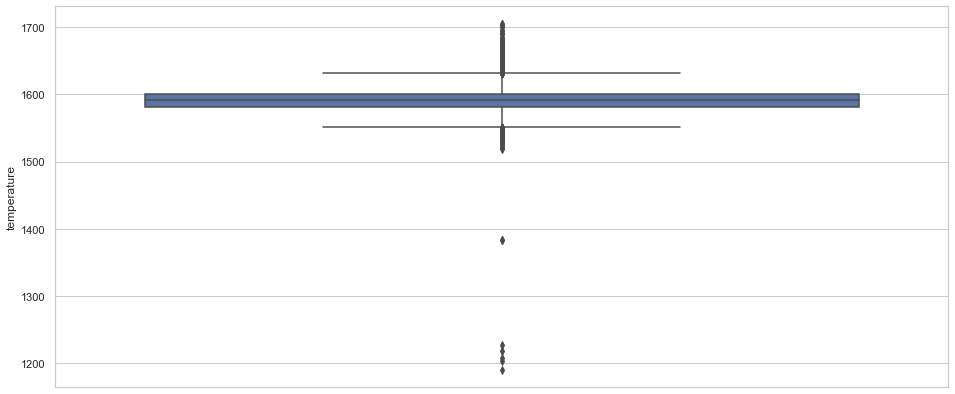

In [38]:
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
sns.boxplot(y=data_temp['temperature'])

<AxesSubplot:xlabel='measure_time', ylabel='temperature'>

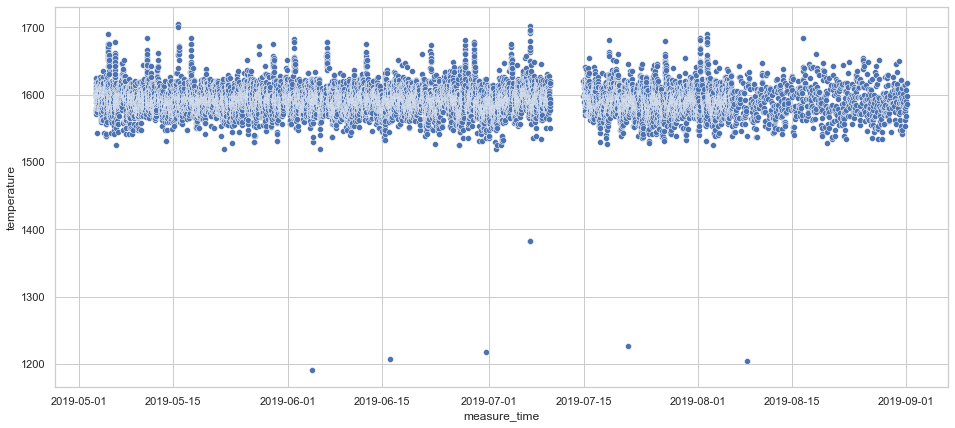

In [39]:
# и посмотрю на диаграмме размаха  
plt.figure(figsize=(16, 7))
sns.scatterplot(data=data_temp, x='measure_time', y='temperature')

Заметна такая же дыра в данных, что и в случае данных по нагреву (при этом в случае нагрева пропусков в таблице не было вообще, а здесь нету пропусков в данных по времени, то есть период примерно с 10 по 15 июля - это период с которого данных не видно в принципе).  
Заметно шесть низких значений, в то же время базово в работе мы исхоим из того, что данные реальные и аномалий там быть не должно (об этом была речь и на консультации) - на них можно будет посмотреть, но в принципе сильной аномалией они могут и не являтся.   
Еще один заметный момент - разреженность данных по температуре примерно после 5 августа

Важная особенность этой таблицы - в ней целевой признак

### Данные по проволоке (data_wire)

In [40]:
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [42]:
data_wire.corr()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,1.000000,-0.083352,-0.005461,-0.084460,0.389064,NaN,0.082274,0.578898,0.323891,-0.012200
Wire 1,-0.083352,1.000000,-0.030892,0.724370,0.054001,NaN,-0.280807,-0.035072,0.068697,0.010104
Wire 2,-0.005461,-0.030892,1.000000,-0.081852,NaN,NaN,-0.265706,NaN,0.250477,0.011019
Wire 3,-0.084460,0.724370,-0.081852,1.000000,0.069854,NaN,-0.221602,-0.056948,NaN,NaN
Wire 4,0.389064,0.054001,NaN,0.069854,1.000000,NaN,0.237456,-0.404865,NaN,NaN
Wire 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 6,0.082274,-0.280807,-0.265706,-0.221602,0.237456,NaN,1.000000,-0.224093,NaN,NaN
Wire 7,0.578898,-0.035072,NaN,-0.056948,-0.404865,NaN,-0.224093,1.000000,NaN,NaN
Wire 8,0.323891,0.068697,0.250477,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
Wire 9,-0.012200,0.010104,0.011019,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


Ситуация очень похожа на ситуацию с data_bulk, некоторых значений очень мало, при этом значения выглядят в целом нормально. Заметно наличие пропусков в key, посмотрю на данные по времени (как и в случае c bulk решил пока не переводить в змеиный регистр, даты переведу в datetime)

корреляций между wire меньше, чем в случае c bulk (скорее даже их нет - самые заментые корреляции со столбцом key, что должно быть артефактом)

In [43]:
try:
    data_wire_time = pd.read_csv(data_path + '/data_wire_time.csv', parse_dates=[1,2,3,4,5,6,7,8,9])
except:
    data_wire_time = pd.read_csv(data_path2 + '/data_wire_time.csv', parse_dates=[1,2,3,4,5,6,7,8,9])

In [44]:
data_wire_time.describe(include=['datetime64'])

C:\Users\v.kozlovskiy\AppData\Local\Temp\ipykernel_22584\1014138219.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data_wire_time.describe(include=['datetime64'])
C:\Users\v.kozlovskiy\AppData\Local\Temp\ipykernel_22584\1014138219.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data_wire_time.describe(include=['datetime64'])
C:\Users\v.kozlovskiy\AppData\Local\Temp\ipykernel_22584\1014138219.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=Tr

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055,1079,63,14,1,73,11,19,29
unique,3055,1079,63,14,1,73,11,19,29
top,2019-05-03 11:11:41,2019-05-03 13:32:06,2019-05-04 04:47:53,2019-05-07 08:48:23,2019-08-08 16:01:07,2019-05-07 08:37:20,2019-07-23 12:42:00,2019-05-14 00:03:32,2019-05-04 16:09:11
freq,1,1,1,1,1,1,1,1,1
first,2019-05-03 11:11:41,2019-05-03 13:32:06,2019-05-04 04:47:53,2019-05-07 08:48:23,2019-08-08 16:01:07,2019-05-07 08:37:20,2019-07-23 12:08:44,2019-05-14 00:03:32,2019-05-04 16:09:11
last,2019-09-01 04:16:01,2019-08-31 18:50:15,2019-08-28 02:11:18,2019-08-08 12:03:12,2019-08-08 16:01:07,2019-08-14 00:59:11,2019-08-08 18:27:34,2019-08-11 15:09:29,2019-08-29 03:51:31


все значения времени уникальны, выглядят естественно

## Вывод по знакомству с данными

на основании знакомства с данными (а также первых попыток найти решение и результатов обсуждения (и треда), из которых некоторыем моменты стали яснее) у меня появились такие мысли:

- целевой признак последнее измерение температуры, при этом дргуим признаком является первое (но не другие) измерения
- один ключ (партия стали) должны соответствовать одному наблюдению
- выбросы и аномалии есть, но их мало и к их обрабтке надо подходить осторожно
- если отсутствует целевой признак (последнее измерение температуры), то данные отбрасываются (если отсутствует первое, то тоже)
- явно решается задача регрессии
- данные по нагреву данны по большому числу измерений и из них надо извелчь признаки для каждого ключа (мне кажется оптимальным среднее значение сгруппированное по key)
- из describe видно, что разброс значений key во всех датасетах от 1 до 3241 (до группировки трудно сказать насколько полно представлены значения key в data_arc и data_temp). В данных по сыпучим веществам и проволоке явно не все значения key, в данных по газу отсутствует одно
- глядя на данные по сыпучим веществам и проволоке несколько столбцов хочу удалить, а для оставшихся применить уменьшение размерности с помощью k-means и использовать эти данные как признаки (такая мысль возникает из-за очень большого числа пропусков в них, которе говорит о том, что их не добавляли - а отсутствие это тоже данные + из-за того что эта тема в последнем спринте была и мне кажется здесь применимой)

<a id='step_2'></a>
# Подготовка подробного плана работы  

- Вводная часть

-- Описание проекта  
-- Описание данных  
-- Цель проекта  
-- Задачи проекта   

- [1 Знакомство с данными](#step_1)  

-- Установка библиотек (если требуется)  
-- Создание ячейки импорта  
-- Открытие файлов и первый взгляд на данные    
-- Более продробное знакомство с данными    
-- Вывод по знакомству с данными  

- [2 Подготовка подробного плана работы](#step_2)  

-- Расписать подробный план по пунктам

- [3 Предобработка данных](#step_3)

-- Data_arc - потребуется удалить выброс в power_reactive и посмотреть на другие заметные значения (выходившие за пределы усов), также хочу посмотреть на задвоенную дату (но не думаю, что это имеет особое значение).  
-- Data_bulk и data_wire - планирую удалить некоторые столбцы с совсем малым числом значений (но не особо много)  
-- Data_gas - посмотрю на, то что выходит за пределы усов  
-- Data_temp - также ближе посмотрю на выбивающиеся значения, но не факт, что буду менять/удалять  

- [4 Подготовка признаков](#step_4)

-- Data_arc - мощности не коррелируют - думаю из них лучше сделать два отдельных признака, сгруппировать по ключу и посчитать среднее, возможно имеет смысл посчитать длительность нагрева (об этом говорили на вебинаре)  
-- Data_bulk и data_wire - хочу применить k-means и потом вынести в общую таблицу метки (число классов постараюсь определить методом локтя или ориентируясь на оставшееся число столбцов - возможно попробовать оба варианта - я заметил, что данные в этом проекте считаются быстро поэтому варианты пробовать кажется возможным)  
-- Данные из Data_bulk_time и data_wire_time кажутся не нужными (по моему их онсновной смысл показать, что там где в bulk и time пропуски просто не было событий)  
-- data_gas - добавлю как признак  
-- из data_temp извлеку начальную температуру как признак, и конечную как целевой признак  
-- далее объединю датасеты через key (с помощью merge и outer_join хочу это сделать) и посмотрю на ситуацию с пропусками (то что относится к целевому признаку надо будет удалить, думаю, что остального не будет много)  

- [5 Подбор оптимальной модели и гиперпараметров для неё](#step_5)

-- разделю выборки (на вебинаре обсудили test_size=0.25)  
-- проведу масштабирование признаков (они должны достаточно сильно различаться по своим интервалам значений)   
-- попробую различные модели (планирую Линейную регрессию, RandomForest, LightGBM), проведу кросс-валидацию, постараюсь подобрать оптимальные гиперпараметры 

- [6 Тестирование модели](#step_6)
-- протестирую на тестовой выборке самую оптимальную модель из предыдущего этапа

- [7 Вывод](#step_7)

<a id='step_3'></a>
# Предобработка данных

## Обработка data_arc

In [45]:
data_arc

,key,heating_start,heating_end,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [46]:
# посмотрю на задвоенную дату
data_arc.query('heating_start == "2019-06-10 22:02:03"')

,key,heating_start,heating_end,active_power,reactive_power
4872,1051,2019-06-10 22:02:03,2019-06-10 22:06:02,1.040376,0.635608
4876,1052,2019-06-10 22:02:03,2019-06-10 22:04:31,0.623495,0.508767


это значение у соседних партий, посмотрю на эти партии и на соседние

In [47]:
data_arc.query('key in [1050, 1051, 1052, 1053]')

,key,heating_start,heating_end,active_power,reactive_power
4861,1050,2019-06-10 20:17:08,2019-06-10 20:19:23,0.461524,0.337856
4862,1050,2019-06-10 20:24:04,2019-06-10 20:34:48,2.400327,1.884661
4863,1050,2019-06-10 20:38:32,2019-06-10 20:42:37,0.892129,0.657204
4864,1050,2019-06-10 20:57:38,2019-06-10 21:01:19,0.985150,0.632525
4865,1050,2019-06-10 21:02:06,2019-06-10 21:04:23,0.616041,0.420356
4866,1051,2019-06-10 21:10:52,2019-06-10 21:16:30,1.448011,1.045037
4867,1051,2019-06-10 21:17:31,2019-06-10 21:24:27,2.003559,1.248206
4868,1051,2019-06-10 21:25:37,2019-06-10 21:30:51,1.528554,0.892720
4869,1051,2019-06-10 21:32:03,2019-06-10 21:36:58,1.417861,0.818525
4870,1051,2019-06-10 21:53:30,2019-06-10 21:54:50,0.337850,0.198380


исходя из этих 4-ех партий видно, что они идут последовательно (вообще это кажется логичны, также видно наложение 1051 и 1052)
мне кажется, что в процессе не должно быть наложений (хотя может быть плохо понимаю процесс)
попробую посмотреть на большее число партий и время на графике

<AxesSubplot:xlabel='key', ylabel='heating_start'>

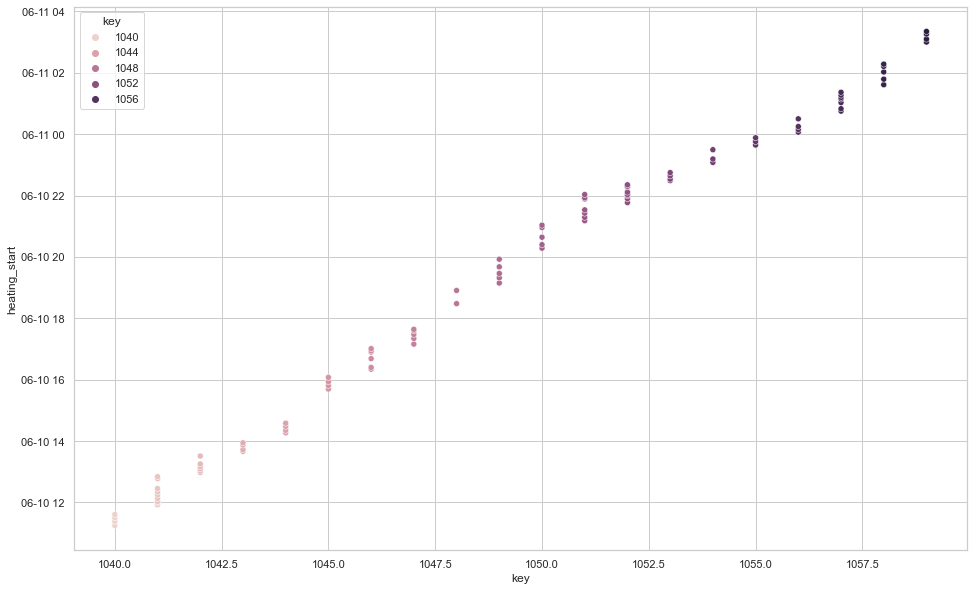

In [48]:
temporary = range(1040, 1060)
plt.figure(figsize=(16, 10))
sns.scatterplot(data=data_arc.query('key in @temporary'), x="key", y="heating_start", hue='key')

тут может быть искажение при взгляде на график, но мне продолжает казаться что партии идут послдовательно (конечно не могу быть на 100% уверен, что так везде, но думаю, что тогда бы возникали еще дубли времени) - 1052 явно накладывается на 1051 - какую-то из этих двух партий хочу удалить, думаю, что лучше 1052 

In [49]:
data_arc = data_arc.query('key != 1052')
data_arc.shape

(14868, 5)

<font color='steelblue'><b>КОД-РЕВЬЮ</b></font><br>
<font color='green'>✔️ Хорошо, давай так попробуем.</font>

In [50]:
# посмотрю на аномалию с reactive_power < 0
data_arc.query('reactive_power < 0')

,key,heating_start,heating_end,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [51]:
data_arc.query('key == 2116')

,key,heating_start,heating_end,active_power,reactive_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


остальные значения выглядят нормально, но думаю, что еще одну партию с аномалией тоже можно удалить

In [52]:
data_arc = data_arc.query('key != 2116')
data_arc.shape

(14864, 5)

<font color='steelblue'><b>КОД-РЕВЬЮ</b></font><br>
<font color='green'>✔️ Верно, реактивная мощность не может быть отрицательной.</font>

Text(0.5, 1.0, 'reactive_power')

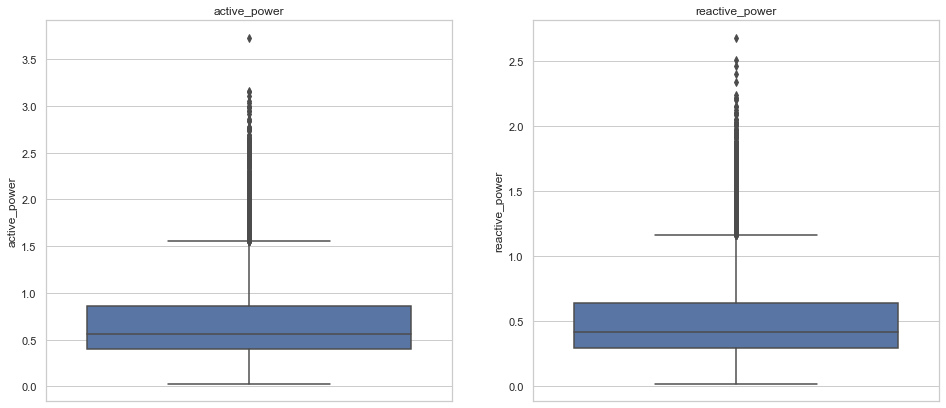

In [53]:
# снова выведу диаграммы размаха 
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)

plt.subplot(1, 2, 1)
sns.boxplot(y=data_arc['active_power'])
plt.title('active_power')

plt.subplot(1, 2, 2)
sns.boxplot(y=data_arc['reactive_power'])
plt.title('reactive_power')

посмотрю на самые выбивающиеся значения для обоих столбцов

In [54]:
data_arc.query('active_power > 2.7').sort_values(by='key')

,key,heating_start,heating_end,active_power,reactive_power
239,51,2019-05-05 05:49:45,2019-05-05 05:59:56,2.772319,1.872731
2661,580,2019-05-24 18:06:25,2019-05-24 18:18:29,2.940772,2.211983
2925,638,2019-05-26 20:43:23,2019-05-26 20:53:36,2.837007,1.724475
2939,640,2019-05-27 01:25:40,2019-05-27 01:38:06,2.766592,2.236813
4654,1005,2019-06-09 05:59:14,2019-06-09 06:11:19,2.975003,2.006356
5644,1227,2019-06-16 16:56:00,2019-06-16 17:06:54,2.756672,1.874919
7007,1519,2019-06-27 02:13:11,2019-06-27 02:24:04,2.729332,2.054763
7352,1597,2019-06-29 19:04:17,2019-06-29 19:13:46,2.742493,1.710655
7433,1616,2019-06-30 09:07:06,2019-06-30 09:20:06,2.943082,1.998065
7800,1689,2019-07-02 19:57:33,2019-07-02 20:08:31,2.864100,2.150657


In [55]:
data_arc.query('reactive_power > 2').sort_values(by='key')

,key,heating_start,heating_end,active_power,reactive_power
888,189,2019-05-10 08:06:45,2019-05-10 08:17:01,2.349396,2.014428
1439,312,2019-05-15 00:00:26,2019-05-15 00:11:51,2.543666,2.018395
1561,335,2019-05-15 22:25:38,2019-05-15 22:35:50,2.546274,2.016542
2027,437,2019-05-19 12:56:06,2019-05-19 13:07:18,2.661747,2.025214
2543,552,2019-05-23 21:25:35,2019-05-23 21:32:58,0.978527,2.100782
2548,553,2019-05-23 22:09:32,2019-05-23 22:20:02,2.602771,2.117762
2661,580,2019-05-24 18:06:25,2019-05-24 18:18:29,2.940772,2.211983
2939,640,2019-05-27 01:25:40,2019-05-27 01:38:06,2.766592,2.236813
4654,1005,2019-06-09 05:59:14,2019-06-09 06:11:19,2.975003,2.006356
7007,1519,2019-06-27 02:13:11,2019-06-27 02:24:04,2.729332,2.054763


основные мысли - они не очень сильно выбиваются и очень часто это одни и те же партии - мне кажется это говорит о реалистичности данных и о том, что делать с ними ничего не следует

## Обработка data_gas

In [56]:
data_gas

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


<AxesSubplot:ylabel='gas'>

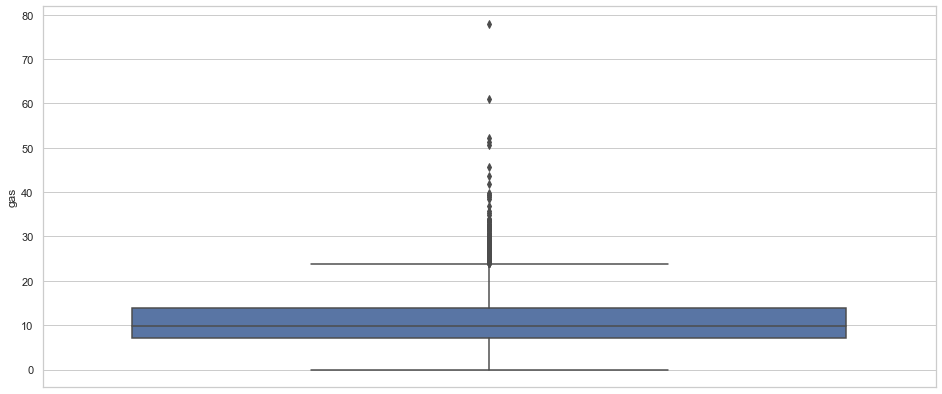

In [57]:
plt.figure(figsize=(16, 7))
sns.boxplot(y=data_gas['gas'])

In [58]:
# посмотрю на выбивающиеся значения
data_gas.query('gas > 40')

,key,gas
116,117,50.581035
277,280,60.935689
319,322,77.995040
660,663,41.854643
1461,1464,43.655411
2105,2108,45.638999
2107,2110,52.142373
2567,2570,51.380229


таких значений немного и они сильно не выбиваются, хочу еще раз посмотреть на данные с разных сторон после подготовки общей таблицы признаков

<font color='steelblue'><b>КОД-РЕВЬЮ</b></font><br>
<font color='green'>✔️ Хорошо.</font>

## Обработка data_temp

In [59]:
# выведу сильно отличающиеся (вниз) значения
data_temp.query('temperature < 1400')

,key,measure_time,temperature
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


In [60]:
# посмотрю как они соотносятся с остальными значениями в партиях
data_temp.query('key in [867, 1214, 1619, 1818, 2052, 2561]')

,key,measure_time,temperature
4350,867,2019-06-04 14:21:00,1191.0
4351,867,2019-06-04 14:29:35,1575.0
4352,867,2019-06-04 14:30:29,1576.0
4353,867,2019-06-04 14:43:10,1571.0
4354,867,2019-06-04 14:52:54,1600.0
4355,867,2019-06-04 14:57:17,1599.0
5978,1214,2019-06-16 05:32:00,1208.0
5979,1214,2019-06-16 05:49:01,1608.0
5980,1214,2019-06-16 05:51:28,1608.0
5981,1214,2019-06-16 05:51:38,1608.0


данные отсортированы по ключу, а потом по времени - так что видно, что низкие температуры всегда в первом измерении (т.е. это может быть вполне реально)

По ходу развития проекта пришла информация, что такие значения (и еще значения меньше 1500) все таки можно удалить 

In [61]:
data_temp.query('temperature < 1500')

,key,measure_time,temperature
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


меньше 1500 те же ключи - удалю все данные этих ключей, чтобы избежать искажений (сделаю это на этапе работы с таблицей признаков)

<a id='step_4'></a>
# Подготовка признаков

## Снижение размерности bulk и wire
Мне показалось возможным применить здесь снижение размерности по ряду причин:  
- не совсем понимал, как свести эти данные иначе (т.е. можно конечно сгруппировать по ключу, посчитав среднее или как-то еще, но признаков будет много + не уверен, что с таким количеством пропусков они будут хорошо группироваться)
- в последнем спринте было обсуждение снижения размерности (логично было предположить, что здесь оно подойдет и мне кажется, что подходит)
- из сопоставления таблиц с данными и временем (bulk и wire) видны сходные размеры и число пропусков - предполагаю, что из этого можно сделать вывод о том, что когда данных нет, то фактически они равны нулю
- в проекте по веществам (сборный проект 2) тоже было много признаков (там я делал функцию, которая выделяла скоррелированные столбцы и удаляла часть из них, не особо вдумываясь в их содержание - ну т.е. смотрел в общем, но каждый признак не анализировал), но когда читал про, то как уменьшить число признаков, видел, что методы снижения размерности как раз применяют и для этого
- здесь хочу применить k-means, т.к. про него было в последнем спринте (и на вебинаре говорилось, что все, что нужно в ходе практикума было представлено), насчет методов подобного плана пока не хочу применять, т.к. опасаюсь, что запутаюсь. можно ли применить здесь что-то типа mds и pca не знаю (возможно это имело бы смысл, но не пониманию как там технически извлечь классы и вообще делать это в питоне, пишу про них, т.к. сталкивался с этими методами раньше, но не в питоне)

In [62]:
# еще раз посмотрю на скоррелированность столбцов и число значений в них
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [63]:
data_bulk.corr()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,1.000000,-0.192066,-0.038643,-0.080335,-0.101955,-0.018074,-0.063539,-0.049425,NaN,0.262741,0.288135,-0.156748,-0.030981,0.050304,-0.149840,-0.169873
Bulk 1,-0.192066,1.000000,-0.073762,0.016731,-0.040465,-0.368980,0.141745,-0.086223,NaN,NaN,-0.278055,0.461895,0.370501,1.000000,0.409188,-0.119006
Bulk 2,-0.038643,-0.073762,1.000000,NaN,0.393882,0.070350,NaN,-0.010043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 3,-0.080335,0.016731,NaN,1.000000,-0.260918,0.144410,0.253080,NaN,NaN,0.072850,-0.244532,0.137997,0.011648,-0.582598,0.026257,-0.023689
Bulk 4,-0.101955,-0.040465,0.393882,-0.260918,1.000000,-0.077214,-0.333841,0.324940,NaN,0.766565,-0.516399,NaN,0.051112,-0.311659,0.022925,0.041190
Bulk 5,-0.018074,-0.368980,0.070350,0.144410,-0.077214,1.000000,-0.511112,0.304476,NaN,NaN,NaN,NaN,0.007650,NaN,-0.256040,-0.248216
Bulk 6,-0.063539,0.141745,NaN,0.253080,-0.333841,-0.511112,1.000000,NaN,NaN,NaN,NaN,-0.104251,-0.079822,0.844690,0.154429,-0.038363
Bulk 7,-0.049425,-0.086223,-0.010043,NaN,0.324940,0.304476,NaN,1.000000,NaN,NaN,NaN,NaN,0.538671,NaN,1.000000,NaN
Bulk 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 9,0.262741,NaN,NaN,0.072850,0.766565,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.946954,NaN,-0.479974,NaN


Исходно не уверен, что столбцы с малым (например менее 10%) числом значений надо удалять все - думаю, что точно не нужен bulk 8 (одно значение). Насчет удаления заметно коррелирующих тоже не уверен, что, например, все больше 0,7 по модулю надо удалять. Думаю есть смысл удалить те столбцы, где заметны ощутимые корреляции но данных мало это:   
- bulk 13 (18 значений, коррелирует с bulk 6 и bulk 12)
- bulk 7 (25 значений и есть некоторая связь с bulk 12)
- bulk 9 (19 значений и сильная связь с bulk 12)

bulk 2, несмотря на малое число значений пока попробую оставить

**после многих итераций построения моделей решил, что лучше ничего не удалять - код с удалением пока закомментировал**

еще хочу выделить столбец с сумой сыпучих веществ (и аналогично для проволоки потом) и добавить их в таблицу признаков

In [64]:
# сделаю датасет для k-means, удалю ключ и столбцы, которые планировал удалить
data_bulk_km = data_bulk.drop(['key'], axis=1)

# на всякий случай выделю столбец с сумой сыпучих веществ
data_bulk['total_bulk'] = data_bulk_km.sum(axis=1)

In [65]:
# заполню пропуски
data_bulk_km = data_bulk_km.fillna(0)

In [66]:
data_bulk_km

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


In [67]:
data_bulk_km.shape

(3129, 15)

Число классов пробую подобрать с помощью метода локтя описанного в последнем спринте (ориентируюсь на код применявшийся там). Не представляю можно ли здесь задать и какие начальные центроиды - не буду пробовать их задавть

In [68]:
distortion = []
K = range(1, 30)
for k in K:
    model = KMeans(n_clusters=k, random_state=250722)
    model.fit(data_bulk_km)
    distortion.append(model.inertia_) 

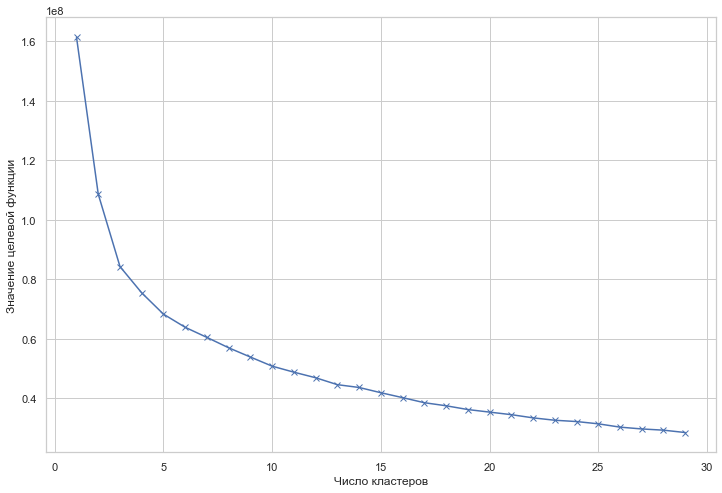

In [69]:
# выведу график
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show() 

в общем график идет не так хорошо, как шел в спринте. Выбирал между тем чтобы выбрать этап где график прекращает резко снижаться или выбрать большее число кластеров (помня про число признаков в таблице хотя не думаю, что на него надо сильно смотреть) - пока попробую выбрать 4 кластера

In [70]:
model = KMeans(n_clusters=4, random_state=250722)
model.fit(data_bulk_km)

KMeans(n_clusters=4, random_state=250722)

In [71]:
model.labels_

array([1, 1, 1, ..., 2, 2, 2])

In [72]:
# сделаю столбец с метками классов в таблицу с bulk
data_bulk['bulk_class'] = model.labels_.astype(int) 

In [73]:
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,total_bulk,bulk_class
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,553.0,1
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,582.0,1
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,544.0,1
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,595.0,1
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,584.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0,758.0,1
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0,594.0,1
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0,630.0,2
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0,272.0,2


**аналогично буду действовать с wire**

In [74]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [75]:
data_wire.corr()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,1.000000,-0.083352,-0.005461,-0.084460,0.389064,NaN,0.082274,0.578898,0.323891,-0.012200
Wire 1,-0.083352,1.000000,-0.030892,0.724370,0.054001,NaN,-0.280807,-0.035072,0.068697,0.010104
Wire 2,-0.005461,-0.030892,1.000000,-0.081852,NaN,NaN,-0.265706,NaN,0.250477,0.011019
Wire 3,-0.084460,0.724370,-0.081852,1.000000,0.069854,NaN,-0.221602,-0.056948,NaN,NaN
Wire 4,0.389064,0.054001,NaN,0.069854,1.000000,NaN,0.237456,-0.404865,NaN,NaN
Wire 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 6,0.082274,-0.280807,-0.265706,-0.221602,0.237456,NaN,1.000000,-0.224093,NaN,NaN
Wire 7,0.578898,-0.035072,NaN,-0.056948,-0.404865,NaN,-0.224093,1.000000,NaN,NaN
Wire 8,0.323891,0.068697,0.250477,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
Wire 9,-0.012200,0.010104,0.011019,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


wire 5 удалю, а остальные с малым числом значений попробую оставить - мне кажется они не должны мешать, но вдруг несут какой-то небольшой смысл

**после многих итераций построения моделей решил, что лучше ничего не удалять - код с удалением пока закомментировал**

In [76]:
data_wire_km = data_wire.drop(['key'], axis=1)

# на всякий случай выделю столбец с сумой проволоки веществ
data_wire['total_wire'] = data_wire_km.sum(axis=1)

In [77]:
data_wire_km = data_wire_km.fillna(0)

In [78]:
data_wire_km

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3076,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
data_wire_km.shape

(3081, 9)

In [80]:
distortion = []
K = range(1, 30)
for k in K:
    model = KMeans(n_clusters=k, random_state=250722)
    model.fit(data_wire_km)
    distortion.append(model.inertia_) 

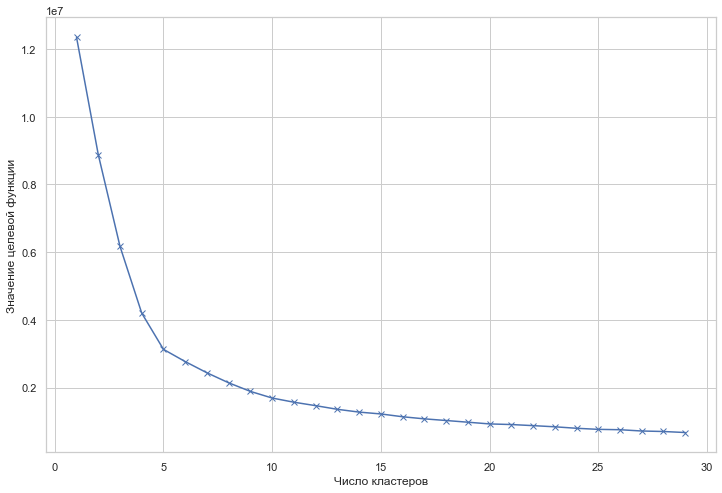

In [81]:
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show() 

Здесь попробую взять 5 классов

In [82]:
model = KMeans(n_clusters=5, random_state=250722)
model.fit(data_wire_km)

KMeans(n_clusters=5, random_state=250722)

In [83]:
model.labels_

array([1, 0, 0, ..., 2, 1, 1])

In [84]:
# сделаю столбец с метками классов в таблицу с wire
data_wire['wire_class'] = model.labels_.astype(int) 

In [85]:
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,total_wire,wire_class
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.059998,1
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.052315,0
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.160157,0
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.063515,0
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.352796,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.088959,1
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.128799,1
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143.357761,2
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.070400,1


## Выцепление первых и последних температур
  
Исходно это для меня одна из самых туманных задач была - решение вероятнее всего очень примитивное, но это первое до чего я додумался (сделать через цикл, при этом первые значения в первые температуры поставить до него, а последние в последние после). По ходу проектов ревьюеры всегда рекомендовали использовать apply (т.к. он быстрее и короче) - часто я сначал делал цикл, а потом лучше понимал как через apply сделать, но здесь не пониманию, как apply применить. Но цикл здесь работает достаточно быстро.  

В итоге планирую сделать три таблицы: 1. с начальной температурой 2. с конечной температурой 3. со всеми температурами кроме конечной (после вебинара понял, что она не нужна для анализа, но т.к. делал её в ходе первых попыток обработки мне кажется, что из неё показательный график можно сделать)

In [86]:
data_temp.head(15)

,key,measure_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [87]:
data_temp.tail(15)

,key,measure_time,temperature
15892,3239,2019-09-01 02:23:02,NaN
15893,3239,2019-09-01 02:24:15,NaN
15894,3240,2019-09-01 02:39:01,1617.0
15895,3240,2019-09-01 02:48:33,NaN
15896,3240,2019-09-01 03:03:21,NaN
15897,3240,2019-09-01 03:12:19,NaN
15898,3240,2019-09-01 03:19:09,NaN
15899,3240,2019-09-01 03:31:27,NaN
15900,3240,2019-09-01 03:34:31,NaN
15901,3240,2019-09-01 03:35:16,NaN


In [88]:
data_temp.shape

(15907, 3)

In [89]:
# делаю три списка для ключа, даты и температуры
# по три раза - для первых температур, последних и всех остальных

key_list = []            # cписки для всех темпераутр кроме целевой
measure_list = []
temp_list = []

key_list_feat = []       # списки для первых температур (признак)
measure_list_feat = []
temp_list_feat = []

key_list_tar = []        # списки для последних температур (целевой признак)
measure_list_tar = []
temp_list_tar = []

In [90]:
# заполняю первые значения списко для первых температур начальной строкой таблицы (т.к. он по схеме цикла в нем не заполнится)
key_list_feat.append(data_temp['key'][0])
measure_list_feat.append(data_temp['measure_time'][0])
temp_list_feat.append(data_temp['temperature'][0])

In [91]:
# дальше заполнение идет в 
for i in range(15906):                                   # range на одно значение меньше длины таблицы (последнее значение цикл не заполнит)     
    if data_temp['key'][i] == data_temp['key'][i+1]:    # если i-ое и следущее значение равны, то значения добавляются
        key_list.append(data_temp['key'][i])             # в список без поселдних температур
        measure_list.append(data_temp['measure_time'][i])
        temp_list.append(data_temp['temperature'][i])
        
    if data_temp['key'][i] < data_temp['key'][i+1]:          # если i-ое значение меньше слеудющего, то 
        key_list_tar.append(data_temp['key'][i])               # списки для целевой температуры заполняются i-ым значением
        measure_list_tar.append(data_temp['measure_time'][i])
        temp_list_tar.append(data_temp['temperature'][i])
        
        key_list_feat.append(data_temp['key'][i+1])            # списки для первых температур значениями i+1
        measure_list_feat.append(data_temp['measure_time'][i+1])
        temp_list_feat.append(data_temp['temperature'][i+1])

In [92]:
# отдельно добавляютcя последние значения в списки для целевой температуры
key_list_tar.append(data_temp['key'][data_temp.shape[0]-1])
measure_list_tar.append(data_temp['measure_time'][data_temp.shape[0]-1])
temp_list_tar.append(data_temp['temperature'][data_temp.shape[0]-1])

Дальше сделаю датафреймы и посмотрю на данные (оценю правильно ли сделал)

In [93]:
temp_feature = pd.DataFrame(data=[key_list_feat, measure_list_feat, temp_list_feat], index=['key', 'measure_time', 'temperature'])
temp_feature = temp_feature.T
temp_feature

,key,measure_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:23:19,1576.0
...,...,...,...
3211,3237,2019-08-31 22:44:04,1569.0
3212,3238,2019-08-31 23:30:31,1584.0
3213,3239,2019-09-01 01:31:47,1598.0
3214,3240,2019-09-01 02:39:01,1617.0


In [94]:
temp_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3216 non-null   object        
 1   measure_time  3216 non-null   datetime64[ns]
 2   temperature   3216 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 75.5+ KB


судя по порядку значений в таблице выше и исходной получилось сделать, то что хотел (интересно, что в таблице с первыми значениями полностью отсутствуют пропуски, это сначал было заметно и глядя на конец исходной таблицы)

In [95]:
temp_target = pd.DataFrame(data=[key_list_tar, measure_list_tar, temp_list_tar], index=['key', 'measure_time', 'temperature'])
temp_target = temp_target.T
temp_target

,key,measure_time,temperature
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0
...,...,...,...
3211,3237,2019-08-31 23:05:43,NaN
3212,3238,2019-08-31 23:43:00,NaN
3213,3239,2019-09-01 02:24:15,NaN
3214,3240,2019-09-01 03:35:16,NaN


In [96]:
temp_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3216 non-null   object        
 1   measure_time  3216 non-null   datetime64[ns]
 2   temperature   2477 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 75.5+ KB


здесь тоже получилось сделать, видно, что пропусков много (почти четверть) - но исходно обсуждалось, что ключи с пропусками в целевом признаке будут удалятся

In [97]:
temp_all_not_target = pd.DataFrame(data=[key_list, measure_list, temp_list], index=['key', 'measure_time', 'temperature'])
temp_all_not_target = temp_all_not_target.T
temp_all_not_target

,key,measure_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,2,2019-05-03 11:37:27,1581.0
...,...,...,...
12686,3240,2019-09-01 03:34:31,NaN
12687,3241,2019-09-01 04:03:30,1586.0
12688,3241,2019-09-01 04:16:12,NaN
12689,3241,2019-09-01 04:22:39,NaN


In [98]:
temp_all_not_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12691 entries, 0 to 12690
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           12691 non-null  object        
 1   measure_time  12691 non-null  datetime64[ns]
 2   temperature   10529 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 297.6+ KB


видно, что пропуски не только в целевом признаке, в то же время было заметно, что в первых температурах пропусков нет, посмотрю еще раз на диаграммы рассеяния

<AxesSubplot:xlabel='measure_time', ylabel='temperature'>

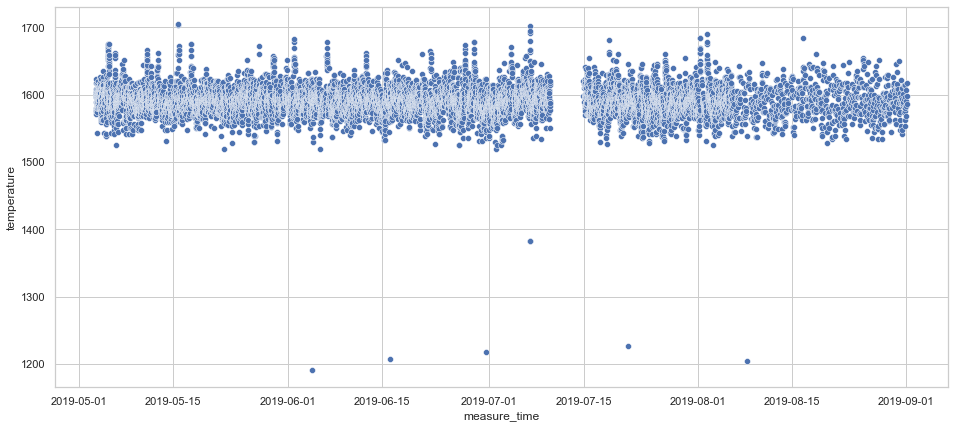

In [99]:
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
sns.scatterplot(data=temp_all_not_target, x='measure_time', y='temperature')

<AxesSubplot:xlabel='measure_time', ylabel='temperature'>

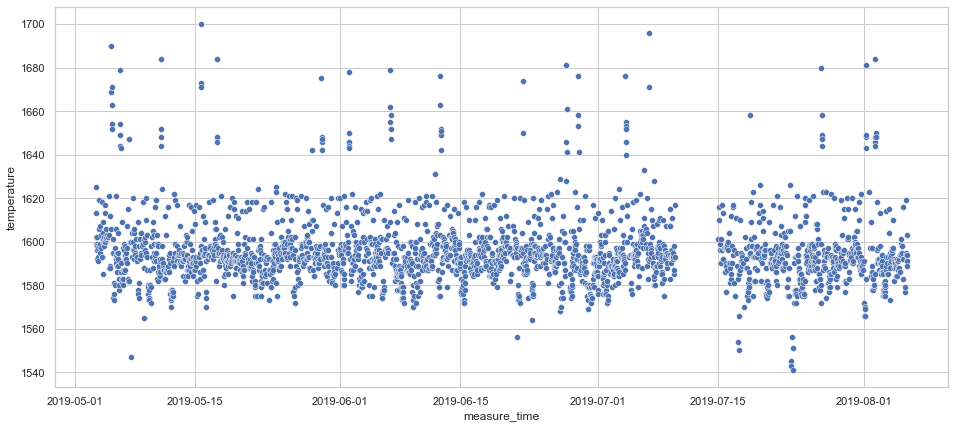

In [100]:
plt.figure(figsize=(16, 7))
sns.scatterplot(data=temp_target, x='measure_time', y='temperature')

видно, что данные по целевому признаку заканчиваются в первой неделе августа. А остальные данные (притом в них нет целевого признака) с этого же времени становятся более разреженными

## Подготвка данных по газу

In [101]:
data_gas

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


данные по газу просто присоединю в таблицу признаков

## Подготвка данных по нагреву

In [102]:
data_arc

,key,heating_start,heating_end,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [103]:
# выделю время нагревания
data_arc['heat_time'] = data_arc['heating_end'] - data_arc['heating_start'] 

In [104]:
data_arc

,key,heating_start,heating_end,active_power,reactive_power,heat_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0 days 00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0 days 00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0 days 00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0 days 00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0 days 00:02:28
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0 days 00:02:37
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0 days 00:03:00
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0 days 00:03:04
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0 days 00:00:57


In [105]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14864 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   key             14864 non-null  int64          
 1   heating_start   14864 non-null  datetime64[ns] 
 2   heating_end     14864 non-null  datetime64[ns] 
 3   active_power    14864 non-null  float64        
 4   reactive_power  14864 non-null  float64        
 5   heat_time       14864 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), timedelta64[ns](1)
memory usage: 812.9 KB


In [106]:
format_seconds = lambda t_delta: t_delta.total_seconds()  #  функция для перевода времени нагревания в секунды

In [107]:
data_arc['heat_time_seconds'] = data_arc['heat_time'].apply(format_seconds) # применение функции

In [108]:
# промежуточное вычисление удалю
data_arc = data_arc.drop('heat_time', axis=1)

In [109]:
data_arc

,key,heating_start,heating_end,active_power,reactive_power,heat_time_seconds
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,157.0
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,180.0
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,184.0
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,57.0


In [110]:
data_arc.describe()

,key,active_power,reactive_power,heat_time_seconds
count,14864.000000,14864.000000,14864.000000,14864.000000
mean,1615.388792,0.670577,0.500821,171.708356
std,934.821272,0.408175,0.310871,98.183373
min,1.000000,0.030002,0.020806,11.000000
25%,805.750000,0.395503,0.291066,107.000000
50%,1617.000000,0.555646,0.416402,147.000000
75%,2429.250000,0.857121,0.637476,214.000000
max,3241.000000,3.731596,2.676388,907.000000


<AxesSubplot:ylabel='heat_time_seconds'>

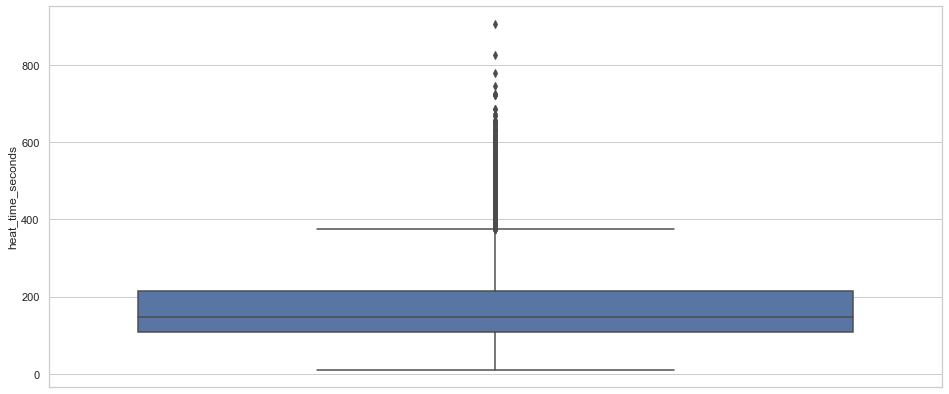

In [111]:
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
sns.boxplot(y=data_arc['heat_time_seconds'])

Разброс у времени нагрева достаточно заметный, хотя отличающиеся цифры не выглядят совсем аномальными

In [112]:
#дальше сгруппирую таблицу по key для столбцов с мощностью и временем нагрева, хочу выводить среднее для каждой партии
data_arc_grouped = data_arc.groupby('key')['active_power', 'reactive_power', 'heat_time_seconds'].agg('mean')

C:\Users\v.kozlovskiy\AppData\Local\Temp\ipykernel_22584\1515101212.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_arc_grouped = data_arc.groupby('key')['active_power', 'reactive_power', 'heat_time_seconds'].agg('mean')


In [113]:
data_arc_grouped

,active_power,reactive_power,heat_time_seconds
key,,,
1,0.975629,0.636648,219.60
2,0.763150,0.499528,202.75
3,0.505176,0.319815,131.00
4,0.802313,0.515074,185.25
5,0.836793,0.563161,217.25
...,...,...,...
3237,0.786493,0.565692,181.80
3238,0.702176,0.560394,182.00
3239,0.583344,0.388952,152.00


# Подготовка таблицы с features

Теперь хочу собрать все признаки (включая целевой для соспоставимости) в одну таблицу, объединят планирую с помощью merge, тип outer (потом уже буду смотреть на оставшиеся пропуски и решать, что с ними делать) 
начну присоединять с data_gas т.к. там больше всего значений  
(хочу проверять каждое присоединение, поэтому не буду делать циклов)

In [114]:
features_all = data_gas.merge(data_arc_grouped, on = ['key'], how='outer')

In [115]:
features_all.shape

(3241, 5)

длина таблицы уже равна числу партий

In [116]:
features_all

,key,gas,active_power,reactive_power,heat_time_seconds
0,1,29.749986,0.975629,0.636648,219.600000
1,2,12.555561,0.763150,0.499528,202.750000
2,3,28.554793,0.505176,0.319815,131.000000
3,4,18.841219,0.802313,0.515074,185.250000
4,5,5.413692,0.836793,0.563161,217.250000
...,...,...,...,...,...
3236,3239,16.023518,0.583344,0.388952,152.000000
3237,3240,11.863103,0.596817,0.496653,167.800000
3238,3241,12.680959,0.494289,0.339240,131.800000
3239,193,NaN,0.683003,0.504593,173.333333


пока выглядит нормально (видно две партии где не было газа)

In [117]:
#присоединю температуру (признак)
features_all = features_all.merge(temp_feature, on = ['key'], how='outer')

In [118]:
features_all

,key,gas,active_power,reactive_power,heat_time_seconds,measure_time,temperature
0,1,29.749986,0.975629,0.636648,219.600000,2019-05-03 11:16:18,1571.0
1,2,12.555561,0.763150,0.499528,202.750000,2019-05-03 11:37:27,1581.0
2,3,28.554793,0.505176,0.319815,131.000000,2019-05-03 12:13:17,1596.0
3,4,18.841219,0.802313,0.515074,185.250000,2019-05-03 12:52:57,1601.0
4,5,5.413692,0.836793,0.563161,217.250000,2019-05-03 13:23:19,1576.0
...,...,...,...,...,...,...,...
3236,3239,16.023518,0.583344,0.388952,152.000000,2019-09-01 01:31:47,1598.0
3237,3240,11.863103,0.596817,0.496653,167.800000,2019-09-01 02:39:01,1617.0
3238,3241,12.680959,0.494289,0.339240,131.800000,2019-09-01 04:03:30,1586.0
3239,193,NaN,0.683003,0.504593,173.333333,2019-05-10 11:48:54,1593.0


In [119]:
#присоединю температуру (целевой признак)
features_all = features_all.merge(temp_target, on = ['key'], how='outer')

In [120]:
features_all

,key,gas,active_power,reactive_power,heat_time_seconds,measure_time_x,temperature_x,measure_time_y,temperature_y
0,1,29.749986,0.975629,0.636648,219.600000,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,12.555561,0.763150,0.499528,202.750000,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,28.554793,0.505176,0.319815,131.000000,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,18.841219,0.802313,0.515074,185.250000,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,5.413692,0.836793,0.563161,217.250000,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
...,...,...,...,...,...,...,...,...,...
3236,3239,16.023518,0.583344,0.388952,152.000000,2019-09-01 01:31:47,1598.0,2019-09-01 02:24:15,NaN
3237,3240,11.863103,0.596817,0.496653,167.800000,2019-09-01 02:39:01,1617.0,2019-09-01 03:35:16,NaN
3238,3241,12.680959,0.494289,0.339240,131.800000,2019-09-01 04:03:30,1586.0,2019-09-01 04:38:08,NaN
3239,193,NaN,0.683003,0.504593,173.333333,2019-05-10 11:48:54,1593.0,2019-05-10 12:30:21,1595.0


мне показалось (скорее всего только показалось), что на графике температуры была видна некоторая периодичность похожая на недельную) - хочу попробовать вытащить день недели в признак, если будет сразу видна бесполезность, то можно будет сразу удалить (вообще некоторая логика в том, что завод работает по разному в разные дни недели есть)  - ориентироваться буду на дату первого измерения (признак)

In [121]:
format_weekday = lambda w_day: w_day.weekday()  #  функция для выделения дня недели

In [122]:
features_all['weekday'] = features_all['measure_time_x'].apply(format_weekday)

чтобы не запутаться удалю время измерений температуры и переименую столбцы с температурой

In [123]:
features_all = features_all.drop(['measure_time_x', 'measure_time_y'], axis=1)

In [124]:
features_all.columns

Index(['key', 'gas', 'active_power', 'reactive_power', 'heat_time_seconds',
       'temperature_x', 'temperature_y', 'weekday'],
      dtype='object')

In [125]:
features_all.columns = ['key', 'gas', 'active_power', 'reactive_power', 'heat_time_seconds', 
                        'temp_feature', 'temp_target', 'weekday']

Дальше присоединю метки классов из bulk и wire (здесь у меня не получилось выделить два нужных столбца из каждой из таблиц - поэтому удалял все остальные, думаю это плохой путь - если пойму как сделать лучше переделаю)

In [126]:
bulk_classes = data_bulk.drop(['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5',
       'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'], axis=1)

In [127]:
wire_classes = data_wire.drop(['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'], axis=1)

In [128]:
features_all = features_all.merge(bulk_classes, on = ['key'], how='outer')

In [129]:
features_all

,key,gas,active_power,reactive_power,heat_time_seconds,temp_feature,temp_target,weekday,total_bulk,bulk_class
0,1,29.749986,0.975629,0.636648,219.600000,1571.0,1613.0,4.0,553.0,1.0
1,2,12.555561,0.763150,0.499528,202.750000,1581.0,1602.0,4.0,582.0,1.0
2,3,28.554793,0.505176,0.319815,131.000000,1596.0,1599.0,4.0,544.0,1.0
3,4,18.841219,0.802313,0.515074,185.250000,1601.0,1625.0,4.0,595.0,1.0
4,5,5.413692,0.836793,0.563161,217.250000,1576.0,1602.0,4.0,584.0,1.0
...,...,...,...,...,...,...,...,...,...,...
3236,3239,16.023518,0.583344,0.388952,152.000000,1598.0,NaN,6.0,630.0,2.0
3237,3240,11.863103,0.596817,0.496653,167.800000,1617.0,NaN,6.0,272.0,2.0
3238,3241,12.680959,0.494289,0.339240,131.800000,1586.0,NaN,6.0,232.0,2.0
3239,193,NaN,0.683003,0.504593,173.333333,1593.0,1595.0,4.0,714.0,1.0


In [130]:
features_all = features_all.merge(wire_classes, on = ['key'], how='outer')

In [131]:
features_all.head(10)

,key,gas,active_power,reactive_power,heat_time_seconds,temp_feature,temp_target,weekday,total_bulk,bulk_class,total_wire,wire_class
0,1,29.749986,0.975629,0.636648,219.60,1571.0,1613.0,4.0,553.0,1.0,60.059998,1.0
1,2,12.555561,0.763150,0.499528,202.75,1581.0,1602.0,4.0,582.0,1.0,96.052315,0.0
2,3,28.554793,0.505176,0.319815,131.00,1596.0,1599.0,4.0,544.0,1.0,91.160157,0.0
3,4,18.841219,0.802313,0.515074,185.25,1601.0,1625.0,4.0,595.0,1.0,89.063515,0.0
4,5,5.413692,0.836793,0.563161,217.25,1576.0,1602.0,4.0,584.0,1.0,98.352796,0.0
5,6,11.273392,0.988777,0.672294,238.00,1543.0,1596.0,4.0,676.0,1.0,108.224477,0.0
6,7,9.836267,0.636844,0.390324,168.25,1586.0,1599.0,4.0,627.0,1.0,98.061600,0.0
7,8,15.171553,0.940689,0.670174,228.25,1577.0,1598.0,4.0,914.0,0.0,155.282394,2.0
8,9,8.216623,0.416390,0.295734,125.00,1587.0,1592.0,4.0,526.0,1.0,122.536960,0.0
9,10,6.529891,0.487270,0.416019,137.50,1574.0,1593.0,4.0,509.0,1.0,93.620796,0.0


In [132]:
features_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3241 entries, 0 to 3240
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                3241 non-null   object 
 1   gas                3239 non-null   float64
 2   active_power       3212 non-null   float64
 3   reactive_power     3212 non-null   float64
 4   heat_time_seconds  3212 non-null   float64
 5   temp_feature       3216 non-null   object 
 6   temp_target        2477 non-null   object 
 7   weekday            3216 non-null   float64
 8   total_bulk         3129 non-null   float64
 9   bulk_class         3129 non-null   float64
 10  total_wire         3081 non-null   float64
 11  wire_class         3081 non-null   float64
dtypes: float64(9), object(3)
memory usage: 329.2+ KB


видно различное число пропусков, но подавляющее большинство в целевом признаке - думаю сначала их надо удалить (так я понял задание и, то что горовили на вебинаре), а потом посмотреть что останется 

In [133]:
features_all = features_all.dropna(subset=['temp_target'])

In [134]:
features_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 3240
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2477 non-null   object 
 1   gas                2475 non-null   float64
 2   active_power       2473 non-null   float64
 3   reactive_power     2473 non-null   float64
 4   heat_time_seconds  2473 non-null   float64
 5   temp_feature       2477 non-null   object 
 6   temp_target        2477 non-null   object 
 7   weekday            2477 non-null   float64
 8   total_bulk         2408 non-null   float64
 9   bulk_class         2408 non-null   float64
 10  total_wire         2373 non-null   float64
 11  wire_class         2373 non-null   float64
dtypes: float64(9), object(3)
memory usage: 251.6+ KB


ушла большая часть датасета (почти четверть данных, но как я понимаю это необходимое условие - данных по target там не было)
осталось понять, что делать с оставшимися пропусками (для большинства столбцов их нет или мало - по 2), заметное количество осталось для bulk и wire (около 100), был вариант, что пропуски в них можно заполнить еще одним классом.
(попробовал так делать результат становился заметно хуже) - поэтому удалю эти сто значений тоже

In [135]:
# еще удалю ключи с начальными температурами меньше 1500
features_all = features_all.query('key not in [867, 1214, 1619, 1818, 2052, 2561]')
features_all.shape

(2472, 12)

In [136]:
print(features_all['bulk_class'].value_counts())
print(features_all['wire_class'].value_counts())

1.0    1159
0.0     566
2.0     393
3.0     286
Name: bulk_class, dtype: int64
0.0    1042
1.0     525
2.0     488
4.0     290
3.0      24
Name: wire_class, dtype: int64


возможно эти значения лучше было раньше посмотреть, но думаю на этом этапе это тоже нормально, ключ с одним классом уберу. Остальные с небольшим числом значений хочу оставить.  

In [137]:
features_all = features_all.query('wire_class != 3')
features_all.shape

(2448, 12)

Далее решил заменить пропуски в классах на еще один класс - т.к. метрика от этого не ухудшается решил, что так может быть корректнее (хотя не ухудшается она скорее всего потому, что эти значения уходят после удаления других пропусков) 

In [138]:
features_all['bulk_class'] = features_all['bulk_class'].fillna(4)
features_all['wire_class'] = features_all['wire_class'].fillna(0)

In [139]:
features_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2448 entries, 0 to 3240
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2448 non-null   object 
 1   gas                2446 non-null   float64
 2   active_power       2444 non-null   float64
 3   reactive_power     2444 non-null   float64
 4   heat_time_seconds  2444 non-null   float64
 5   temp_feature       2448 non-null   object 
 6   temp_target        2448 non-null   object 
 7   weekday            2448 non-null   float64
 8   total_bulk         2380 non-null   float64
 9   bulk_class         2448 non-null   float64
 10  total_wire         2345 non-null   float64
 11  wire_class         2448 non-null   float64
dtypes: float64(9), object(3)
memory usage: 248.6+ KB


In [140]:
features_all = features_all.dropna()

In [141]:
features_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2299 entries, 0 to 2496
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2299 non-null   object 
 1   gas                2299 non-null   float64
 2   active_power       2299 non-null   float64
 3   reactive_power     2299 non-null   float64
 4   heat_time_seconds  2299 non-null   float64
 5   temp_feature       2299 non-null   object 
 6   temp_target        2299 non-null   object 
 7   weekday            2299 non-null   float64
 8   total_bulk         2299 non-null   float64
 9   bulk_class         2299 non-null   float64
 10  total_wire         2299 non-null   float64
 11  wire_class         2299 non-null   float64
dtypes: float64(9), object(3)
memory usage: 233.5+ KB


температуры почему-то стали object (переведу их в int)

In [142]:
features_all['temp_feature'] = features_all['temp_feature'].astype(int)
features_all['temp_target'] = features_all['temp_target'].astype(int)

In [143]:
features_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2299 entries, 0 to 2496
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2299 non-null   object 
 1   gas                2299 non-null   float64
 2   active_power       2299 non-null   float64
 3   reactive_power     2299 non-null   float64
 4   heat_time_seconds  2299 non-null   float64
 5   temp_feature       2299 non-null   int32  
 6   temp_target        2299 non-null   int32  
 7   weekday            2299 non-null   float64
 8   total_bulk         2299 non-null   float64
 9   bulk_class         2299 non-null   float64
 10  total_wire         2299 non-null   float64
 11  wire_class         2299 non-null   float64
dtypes: float64(9), int32(2), object(1)
memory usage: 215.5+ KB


Дальше выделю признаки и целевой признак

In [144]:
features = features_all.drop(['key', 'temp_target'], axis=1)

In [145]:
target = features_all['temp_target']

In [146]:
features.shape

(2299, 10)

In [147]:
target.shape

(2299,)

In [148]:
# еще раз посмотрю на корреляции
features.corr()

,gas,active_power,reactive_power,heat_time_seconds,temp_feature,weekday,total_bulk,bulk_class,total_wire,wire_class
gas,1.000000,0.098114,0.073202,0.102458,0.037652,-0.091825,0.322109,-0.153049,0.222666,0.121329
active_power,0.098114,1.000000,0.922607,0.947265,-0.505503,0.020659,0.426633,-0.399308,-0.083106,0.002851
reactive_power,0.073202,0.922607,1.000000,0.924285,-0.475022,0.024736,0.377992,-0.372188,-0.120576,-0.008820
heat_time_seconds,0.102458,0.947265,0.924285,1.000000,-0.437345,0.027053,0.383239,-0.368242,-0.102931,-0.010669
temp_feature,0.037652,-0.505503,-0.475022,-0.437345,1.000000,-0.040088,-0.115856,0.103063,0.179627,-0.036804
weekday,-0.091825,0.020659,0.024736,0.027053,-0.040088,1.000000,-0.061886,0.023451,0.010919,0.069075
total_bulk,0.322109,0.426633,0.377992,0.383239,-0.115856,-0.061886,1.000000,-0.822382,0.072597,-0.003180
bulk_class,-0.153049,-0.399308,-0.372188,-0.368242,0.103063,0.023451,-0.822382,1.000000,-0.017685,0.031428
total_wire,0.222666,-0.083106,-0.120576,-0.102931,0.179627,0.010919,0.072597,-0.017685,1.000000,0.548078
wire_class,0.121329,0.002851,-0.008820,-0.010669,-0.036804,0.069075,-0.003180,0.031428,0.548078,1.000000


<AxesSubplot:>

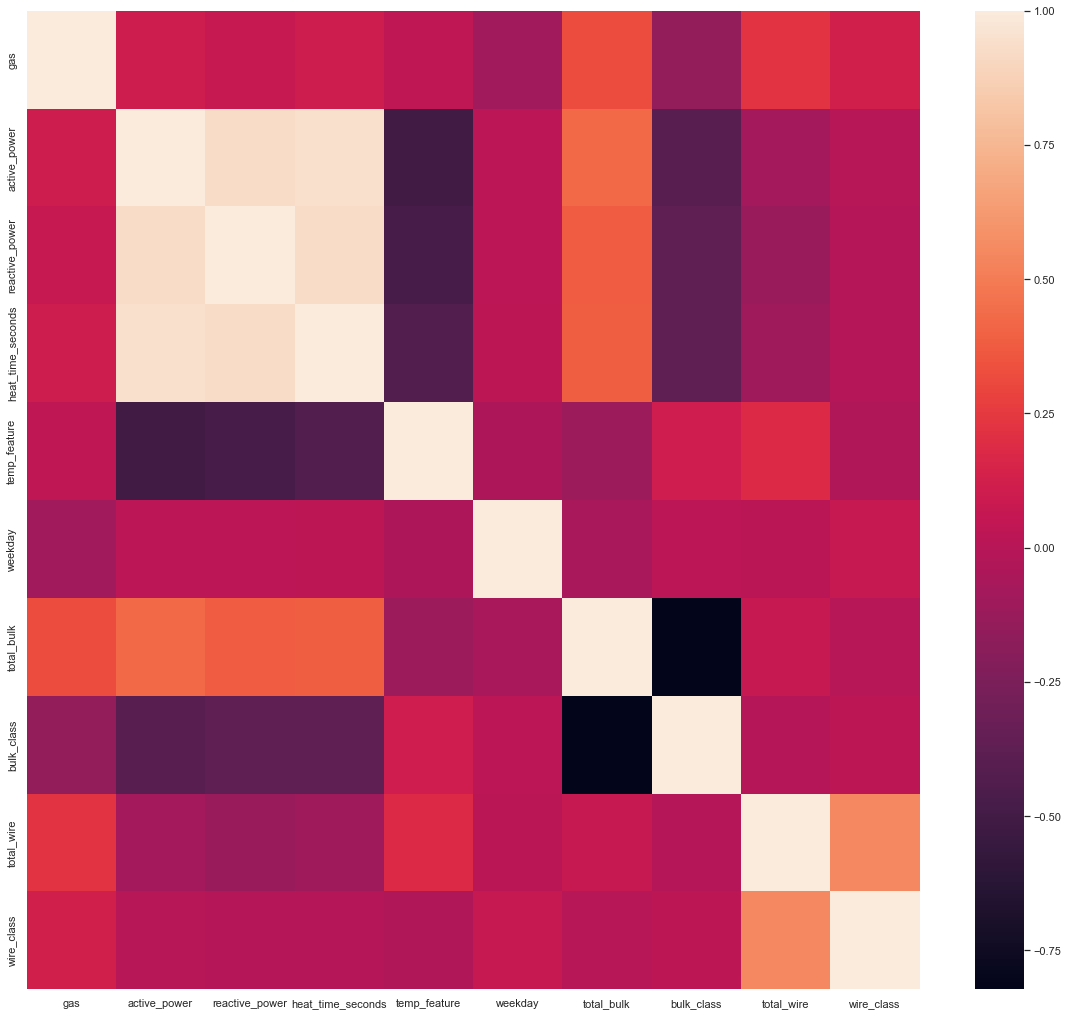

In [149]:
# посмотрю на heatmap для матрицы корреляций
plt.figure(figsize=(20, 18))
sns.heatmap(features.corr())

заменты высокие корреляции между признакми сделанными в data_arc (что ожидаемо, еще видно, что стартовая температура имеет тенденцию к отрицательной корреляции с data_arc)

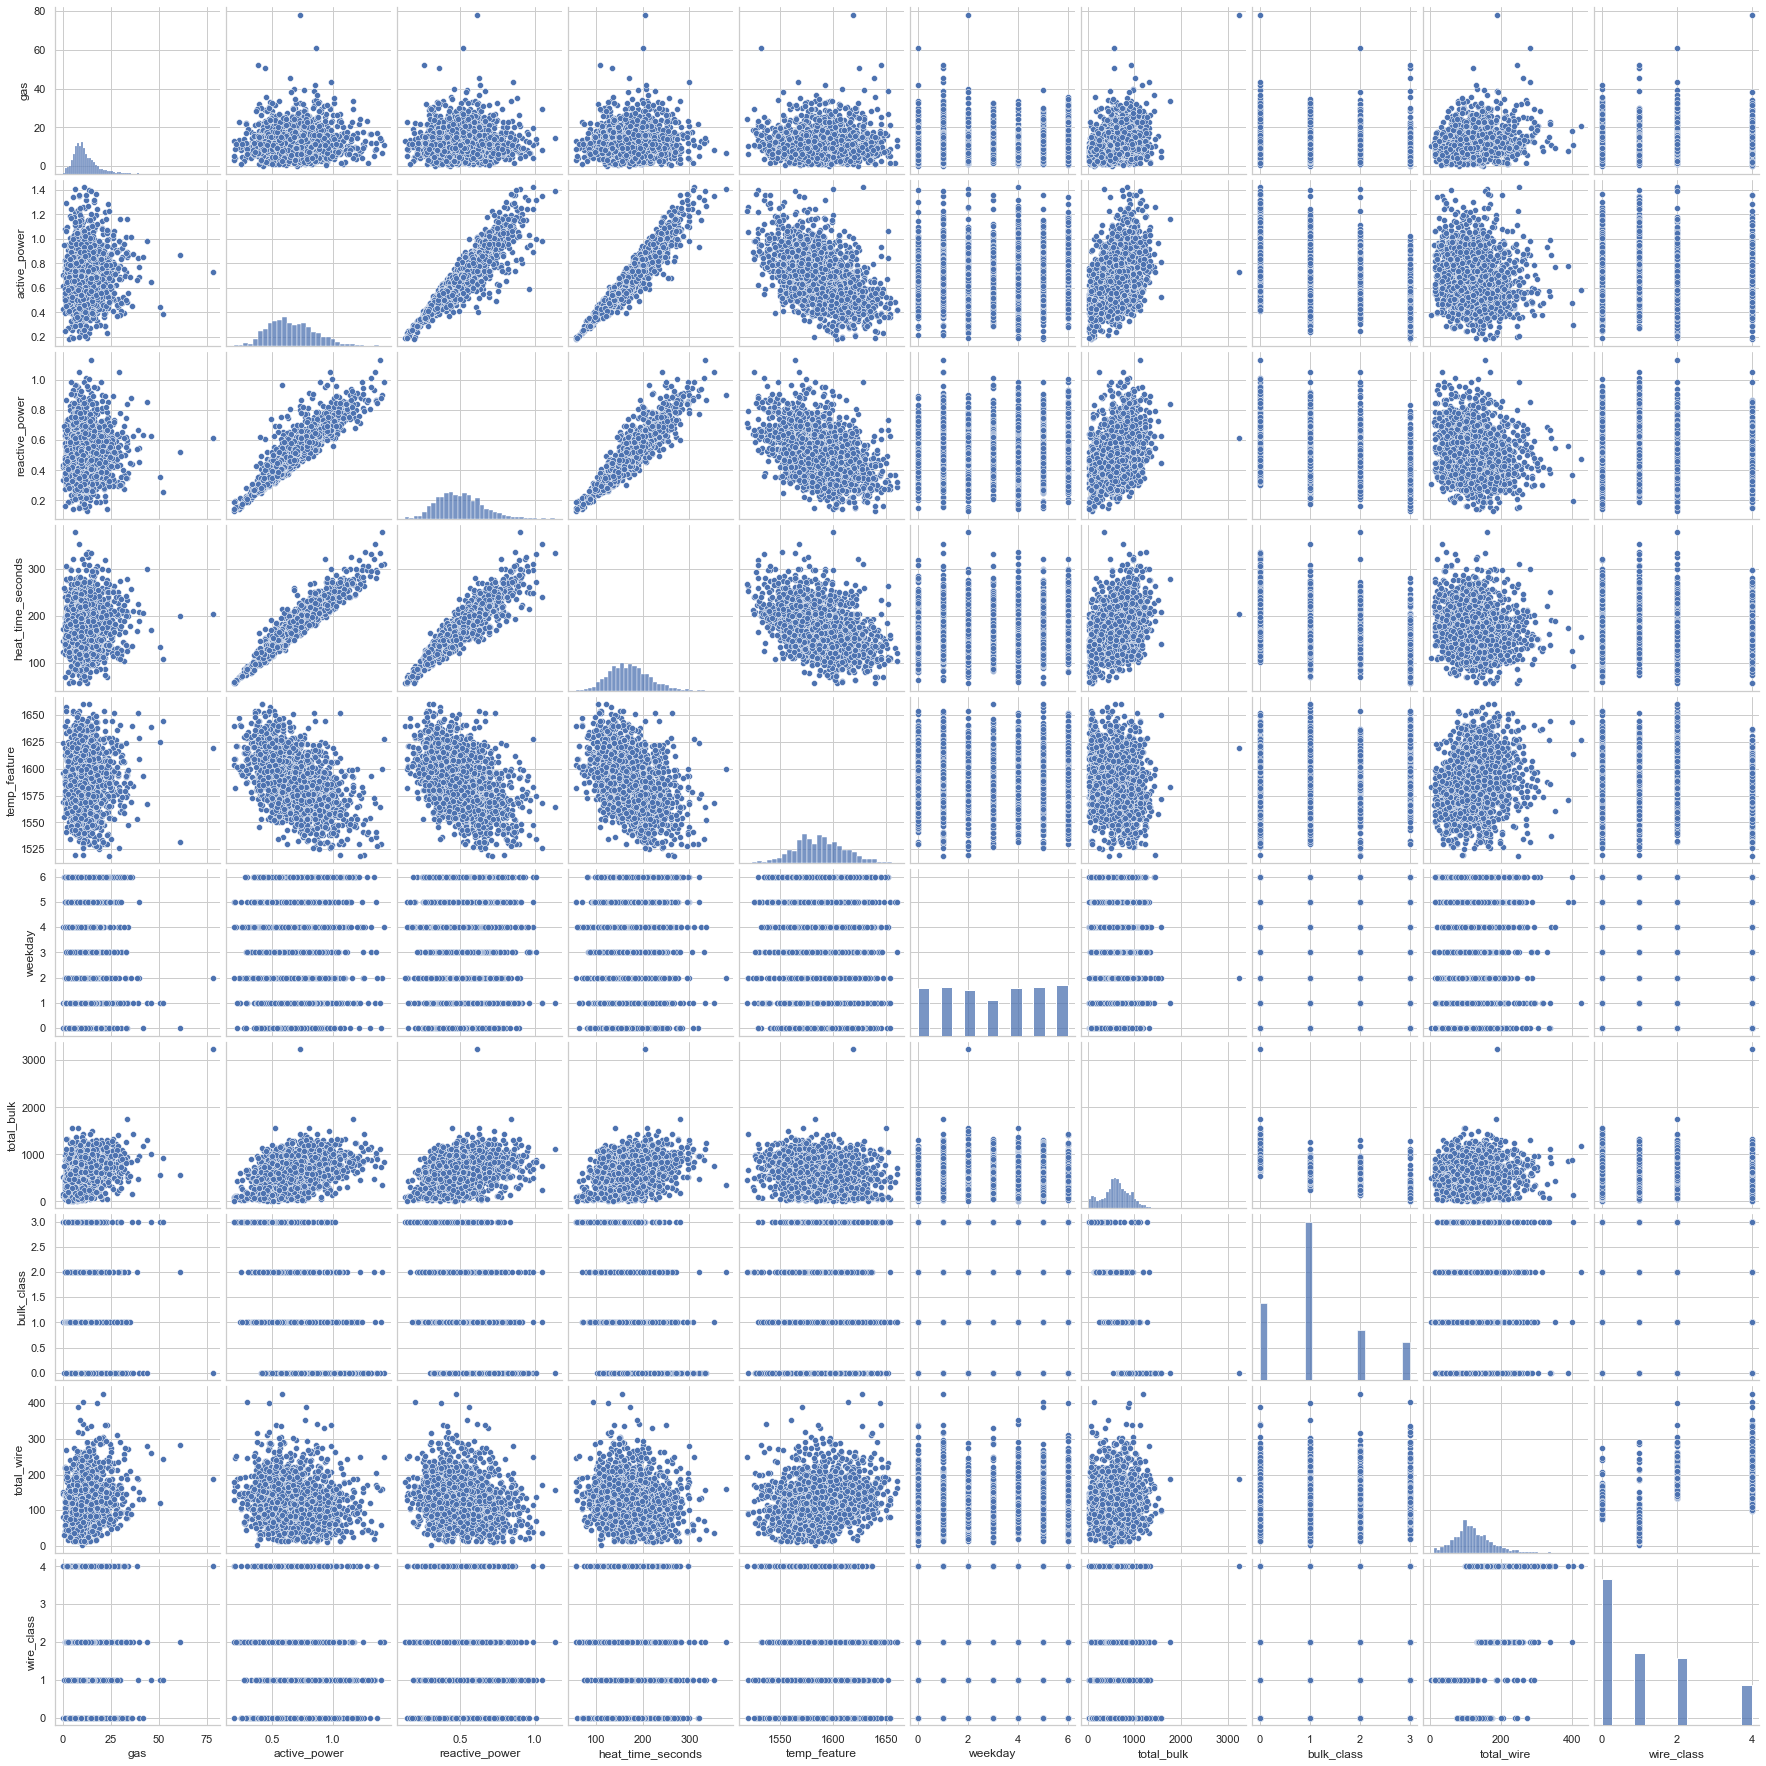

In [150]:
sns.pairplot(features)

здесь мне кжается, что большинство признаков +- нормально распределены (кроме дня недели, и классов по k-means, что ожидаемо)
скоррелированность признаков, созданных в data_arc видна и на pairplot

пробовал множество вариантов удаления признаков самые лучшие сейчас результаты получаются со всеми признаками

 
    
- пробовал удалять единичные редко встречающиеся проволки и сыпучие (с сыпучими иногда больше редких удалял) - после таких вариантов всегда ухудшение шло (хотя сложно представить как из-за столбца с одним значением такие изменения могут происходить)
    
- в проволках удалял класс с малым число значений (это вело к улучшению)    
    
- еще пробовал заменять или не заменять пропуски (их около 100) в классах сыпучих и проволок - метрики не менялись совсем (тоже странно - ведь датасет изменяется, хотя и несильно - думаю, что эти значения потом удаляются с пропусками в total_bulk)


<a id='step_1'></a>
# Подбор оптимальной модели и гиперпараметров для неё

-- разделю выборки (на вебинаре обсудили test_size=0.25)  
-- проведу масштабирование признаков (они должны достаточно сильно различаться по своим интервалам значений)   
-- попробую различные модели (планирую Линейную регрессию, RandomForest, LightGBM), проведу кросс-валидацию, постараюсь подобрать оптимальные гиперпараметры 

**Разделение выборок**

In [151]:
# разделение тестовой и обучающей выборки 
features_train, features_test, target_train, target_test = train_test_split(        
        features, target, test_size=0.25, random_state=250722)

In [152]:
target_train.shape

(1724,)

In [153]:
features_train.shape

(1724, 10)

In [154]:
target_test.shape

(575,)

In [155]:
features_test.shape

(575, 10)

## Выбор моделей и подбор гиперпараметров в случае необходимости

### Линейная регрессия

In [156]:
%%time
# Кросс-валидация для Линейной регрессии
model_linear = LinearRegression()                     # инициализация модели
scores = cross_val_score(model_linear, features_train, target_train, scoring='neg_mean_absolute_error', cv=5)   # кросс-валидация
final_score = scores.mean()                                                  # cредняя оценка качества модели
print(scores)
print('Средняя оценка качества модели (Линеная регрессия, метрика mae):', final_score)
linear_bs = np.abs(final_score)

[-7.36899075 -7.2777295  -7.46242342 -6.61002982 -7.1884595 ]
Средняя оценка качества модели (Линеная регрессия, метрика mae): -7.181526597797591
CPU times: total: 203 ms
Wall time: 40.9 ms


### Desicion Tree Regressor

In [157]:
%%time
# GridSearchCV для DecisionTreeRegressor

clf = DecisionTreeRegressor(random_state=250722)
parametrs = { 'max_depth': range (1, 50, 1) }

grid = GridSearchCV(clf, parametrs, cv=5, scoring='neg_mean_absolute_error')
grid.fit(features_train, target_train)

CPU times: total: 3.53 s
Wall time: 2.6 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=250722),
             param_grid={'max_depth': range(1, 50)},
             scoring='neg_mean_absolute_error')

In [158]:
# выведу лучшие параметры
grid.best_params_

{'max_depth': 4}

In [159]:
# лучший результат
dct_bs = grid.best_score_
dct_bs = np.abs(dct_bs)
dct_bs

7.881228374540673

### Random Forest Regressor

In [161]:
# RandomizedSearch для Random Forest

clf = RandomForestRegressor(random_state=250722)
parametrs = { 'max_depth': range (1, 50, 5),
            'n_estimators': range (1, 50, 5)}

In [162]:
random_cv = RandomizedSearchCV(estimator=clf,
    param_distributions=parametrs,
    cv=5, n_iter=50, 
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1, verbose = 2, 
    return_train_score = True,
    random_state=250722)

In [163]:
%%time
random_cv.fit(features_train, target_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: total: 1.3 s
Wall time: 9.51 s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=250722),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': range(1, 50, 5),
                                        'n_estimators': range(1, 50, 5)},
                   random_state=250722, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=2)

In [164]:
random_cv.best_estimator_

RandomForestRegressor(max_depth=11, n_estimators=46, random_state=250722)

In [165]:
random_cv.best_score_

-7.180988244258906

In [166]:
rfr_bs = random_cv.best_score_
rfr_bs = np.abs(rfr_bs)
rfr_bs

7.180988244258906

### LightGBM Regressor
сначала хочу посмотреть на результат с параметрами по умолчанию

In [167]:
%%time

model_lgbm = LGBMRegressor(random_state=250722)               # инициализация модели
scores = cross_val_score(model_lgbm, features_train, target_train, scoring='neg_mean_absolute_error', cv=5)   # кросс-валидация
final_score = scores.mean()                                                  # cредняя оценка качества модели
print(scores)
print('Средняя оценка качества модели (Линеная регрессия, метрика mae):', final_score)

[-7.34041889 -7.37672167 -7.89824541 -6.59010987 -7.71148711]
Средняя оценка качества модели (Линеная регрессия, метрика mae): -7.383396590327742
CPU times: total: 5.44 s
Wall time: 544 ms


думаю, что можно будет получить результат лучше, чем у RandomForest  
дальше буду запускать каждый параметр отдельно и последовательно (т.к. в противном случае будет очень долго, даже несмотря, на то что здесь данные считаются намного быстрее, чем в других проектах, где эти модели предлагали пробовать впервые (один раз попробовал))  

выбор параметров совпадает с тем, который я делал в других проектах (в основном в проекте по машинам, если протребуется скопирую обоснование, которое там писал - в принципе оно не отличается и в случае этого проекта)

In [168]:
# RandomizedSearch для LightGBM

num_leaves = [10, 50, 100, 200, 300, 400, 500, 700, 1000]
min_child_samples = [10, 20, 50, 100, 200, 400, 1000]
n_estimators = [10, 50, 100, 200, 300, 400, 500, 700, 1000]
learning_rate = [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]

hyperparameter_grid = {'n_estimators': n_estimators,
    'num_leaves': num_leaves,
    'min_child_samples': min_child_samples,
    'learning_rate': learning_rate}

In [169]:
model_lgbm = LGBMRegressor(random_state=250722) 

random_cv = RandomizedSearchCV(estimator=model_lgbm,
    param_distributions=hyperparameter_grid,
    cv=5, n_iter=50, 
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1, verbose = 2, 
    return_train_score = True,
    random_state=250722)

In [170]:
%%time
random_cv.fit(features_train, target_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: total: 2.92 s
Wall time: 16.6 s


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=250722),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [1.0, 0.5, 0.1, 0.05,
                                                          0.01, 0.005, 0.001,
                                                          0.0005, 0.0001],
                                        'min_child_samples': [10, 20, 50, 100,
                                                              200, 400, 1000],
                                        'n_estimators': [10, 50, 100, 200, 300,
                                                         400, 500, 700, 1000],
                                        'num_leaves': [10, 50, 100, 200, 300,
                                                       400, 500, 700, 1000]},
                   random_state=250722, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=2)

In [171]:
lgbm_best_model = random_cv.best_estimator_

In [172]:
random_cv.best_estimator_

LGBMRegressor(learning_rate=0.05, min_child_samples=10, n_estimators=200,
              num_leaves=10, random_state=250722)

In [173]:
lgbm_bs = random_cv.best_score_

In [174]:
lgbm_bs = np.abs(lgbm_bs)
lgbm_bs

7.1490939479388995

### CatBoost Regressor
для более полной картины тестирования моделей хочу также попробовать CatBoost - с этой моделью действовал меньше (пробовал применить в проекте с текстами - там было не очень успешно), гиперпараметры решил пробовать по следующему принципы (тот же что применял в проекте с текстами - цитата оттуда:  

"Из гиперпараметров хочу попробовать варьировать: number_of_trees (оно же iterations как я понял), depth и learning_rate - на сайте они идут первыми в списке и я предположил, что их и надо варьировать в первую очередь. Сначала хочу посмотреть с параметрами, которые указаны в quick start (не знаю считать ли их "параметрами по умолчанию" - но попробую)"

In [175]:
%%time
model_catboost = CatBoostRegressor(iterations=2,
                           depth=2,
                           learning_rate=1,
                           loss_function='MAE',
                           verbose=False)

scores = cross_val_score(model_catboost, features_train, target_train, scoring='neg_mean_absolute_error', cv=3)   # кросс-валидация
final_score = scores.mean()                                                  # cредняя оценка качества модели
print(scores)
print('Средняя оценка качества модели:', final_score)

[-7.70608697 -7.94608699 -7.69512212]
Средняя оценка качества модели: -7.7824320274148695
CPU times: total: 516 ms
Wall time: 342 ms


In [176]:
iterations = [2, 4, 6]
depth = [4, 6, 10]
learning_rate = [0.03, 0.1, 1]

hyperparameter_grid = {'iterations': iterations,
    'depth': depth,
    'learning_rate': learning_rate}

In [177]:
model_catboost = CatBoostRegressor() 

random_cv = RandomizedSearchCV(estimator=model_catboost,
    param_distributions=hyperparameter_grid,
    cv=5, n_iter=27, 
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1, verbose = 2, 
    return_train_score = True,
    random_state=250722)

In [178]:
%%time
random_cv.fit(features_train, target_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0:	learn: 10.1528963	total: 2.05ms	remaining: 10.3ms
1:	learn: 9.5226237	total: 3.82ms	remaining: 7.64ms
2:	learn: 9.2701846	total: 5.56ms	remaining: 5.56ms
3:	learn: 8.9592480	total: 7.29ms	remaining: 3.65ms
4:	learn: 8.7026897	total: 9.03ms	remaining: 1.8ms
5:	learn: 8.5398899	total: 10.9ms	remaining: 0us
CPU times: total: 875 ms
Wall time: 6.18 s


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x0000019E54F28B80>,
                   n_iter=27, n_jobs=-1,
                   param_distributions={'depth': [4, 6, 10],
                                        'iterations': [2, 4, 6],
                                        'learning_rate': [0.03, 0.1, 1]},
                   random_state=250722, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=2)

In [179]:
random_cv.best_estimator_

In [180]:
cb_bs = random_cv.best_score_

In [181]:
cb_bs = np.abs(cb_bs)
cb_bs

7.5800788736575555

### Dummy Regressor
и посмотрю какой результат получается по Dummy Regressor

In [182]:
%%time
# Кросс-валидация для Dummy Regressor
dummy_reg = DummyRegressor(strategy="mean")
scores = cross_val_score(dummy_reg, features_train, target_train, scoring='neg_mean_absolute_error', cv=5)   # кросс-валидация
final_score = scores.mean()                                                  # cредняя оценка качества модели
print(scores)
print('Средняя оценка качества модели (Dummy Regressor, метрика mae):', final_score)
dummy_bs = np.abs(final_score)

[-8.18938529 -8.4259146  -8.85704407 -7.40833622 -8.43248231]
Средняя оценка качества модели (Dummy Regressor, метрика mae): -8.26263249747708
CPU times: total: 15.6 ms
Wall time: 5.03 ms


### Сравнение моделей

In [183]:
table_mae = pd.DataFrame(data=[[dct_bs], [lgbm_bs], [linear_bs], [rfr_bs], [dummy_bs], [cb_bs]], columns=['mae'])
table_mae.index = ['Decision_Tree_Regressor', 'LightGBMRegressor', 'Linear_regression', 'RandomForestRegressor','DummyRegressor', 'CatBoostRegressor']
table_mae.sort_values(by='mae')

,mae
LightGBMRegressor,7.149094
RandomForestRegressor,7.180988
Linear_regression,7.181527
CatBoostRegressor,7.580079
Decision_Tree_Regressor,7.881228
DummyRegressor,8.262632


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


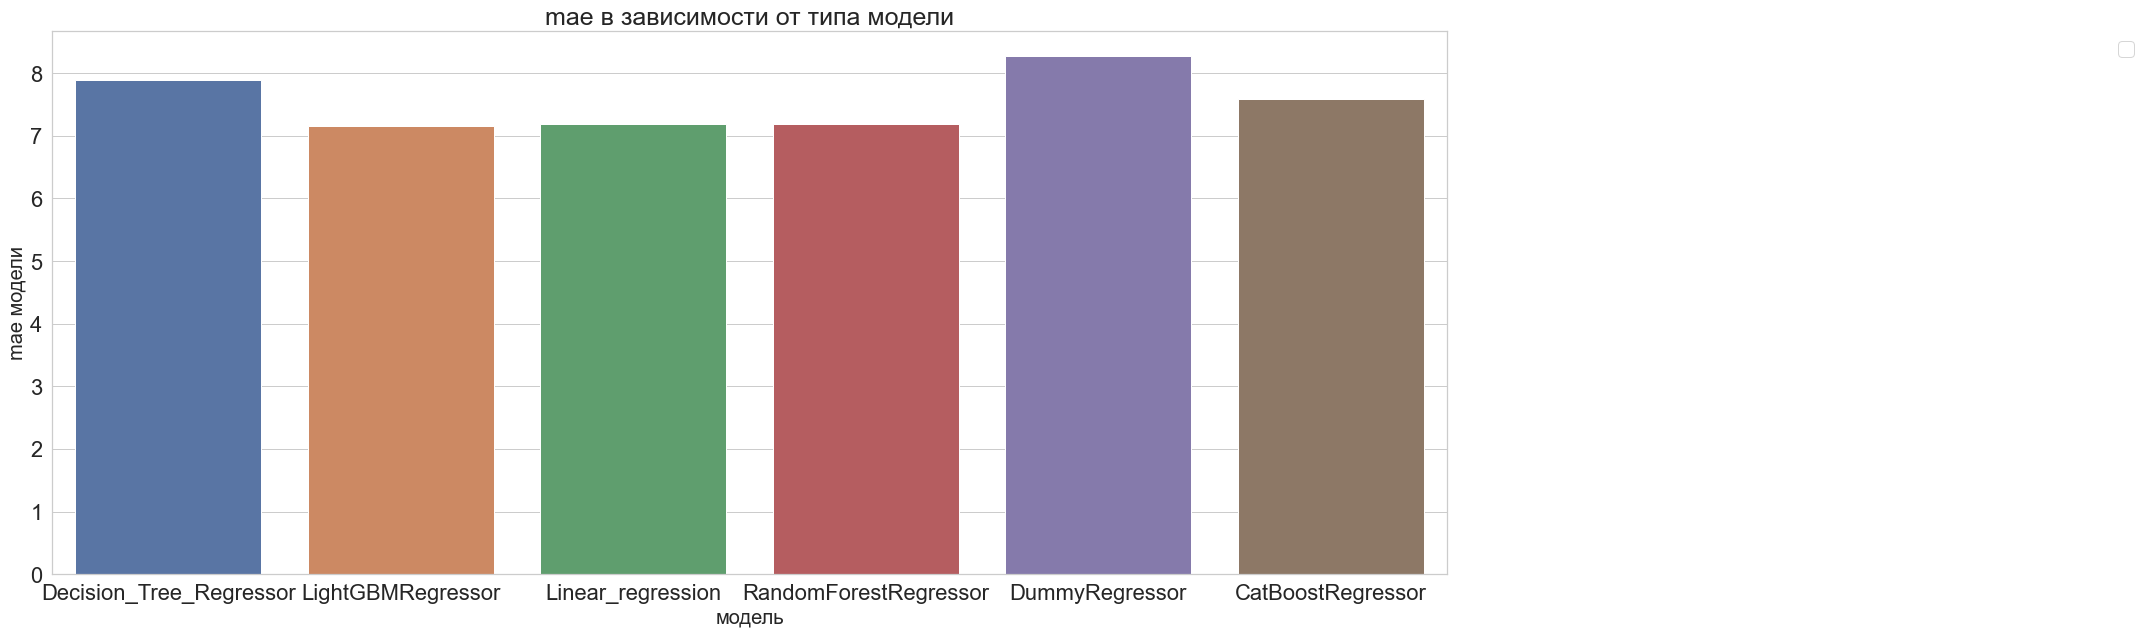

In [184]:
plt.figure(figsize=(25, 10))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=2)

sns.barplot(data=table_mae, x=table_mae.index, y='mae')
plt.xlabel('модель', fontsize=20)
plt.ylabel('mae модели', fontsize=20)            
plt.title('mae в зависимости от типа модели', fontsize=25)
plt.legend(bbox_to_anchor = (1.5,1), fontsize=20)

<a id='step_6'></a>
# Тестирование модели

In [185]:
%%time

model_lgbm_p = lgbm_best_model               # подставил выдчау из RandomizedSearch с параметрами модели

model_lgbm_p.fit(features_train, target_train)
predictions_lbm_p = model_lgbm_p.predict(features_test)
mae_score_test = mean_absolute_error(target_test, predictions_lbm_p)               # подсчет mae
print(f'mae по LGBMRegressor c подобранными гиперпараметрами на тестовой выборке: {mae_score_test:.4f}')

mae по LGBMRegressor c подобранными гиперпараметрами на тестовой выборке: 6.5898
CPU times: total: 891 ms
Wall time: 156 ms


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

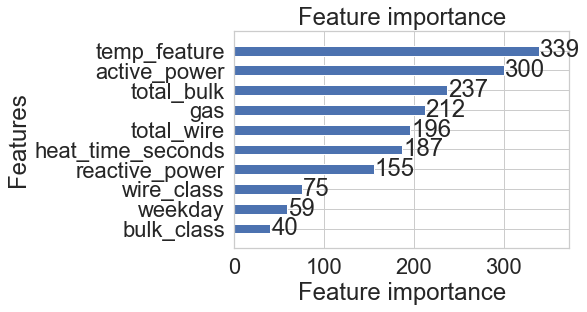

In [186]:
# выведу и здесь feature importance
lgb.plot_importance(model_lgbm_p, height=.5)

<a id='step_7'></a>
# Выводы

- На тестовой выборке с помощью с помощью **LightGBM Regressor получена МАЕ 6.5898** (в прошлой версии на LinearRegression получена MAE 6.6331, в позапрошлой на LightGBM Regressor полученна MAE = 6.7050  до удаления аномальных температур было 6.9078)
- Линейная регрессия в итоге LightGBM показала результат лучше, чем другие модели, которые пробовал использовать, LightGBM всегда знаимает второе место
- Все модели на кросс-валидации давали результат лучше, чем DummyRegressor
- в итоге использовано около 75% от первоначальных данных (но было условие удалять данные если нет целевого признака)
- данные по целевому признаку отсутствуют примерно с 5-го августа, притом данные по начальной температуре есть везде где были измерения температуры, после 5-го августа прослеживается разреженность в данных по температуре (последних там в любом случае уже нет)
- завод вероятно не работал 10-15 июля

- после удаления аномальных значений по температуре результаты на кросс-валидации становились хуже, зато на тестовой выборке лучше

# Отчет по решению

## Вводная часть

В задании указаны слеудющие пункты:

- Какие пункты плана были выполнены, а какие — нет (поясните почему)?
- Какие трудности возникли и как вы их преодолели?
- Какие ключевые шаги в решении задачи выделили?
- Какая ваша итоговая модель и какое у неё качество?

На первые два вопроса планирую отвечать исходя из плана, который повторю в ячейки ниже для наглядности. Затем отвечу на 3-ий и 4-ый.  

Затем в отдельном мункте выведу: **перечисление использовавшихся признаков и описание их предобработки**


## Подробный план работы  

- Вводная часть

-- Описание проекта  
-- Описание данных  
-- Цель проекта  
-- Задачи проекта   

- [1 Знакомство с данными](#step_1)  

-- Установка библиотек (если требуется)  
-- Создание ячейки импорта  
-- Открытие файлов и первый взгляд на данные    
-- Более продробное знакомство с данными    
-- Вывод по знакомству с данными  

- [2 Подготовка подробного плана работы](#step_2)  

-- Расписать подробный план по пунктам

- [3 Предобработка данных](#step_3)

-- Data_arc - потребуется удалить выброс в power_reactive и посмотреть на другие заметные значения (выходившие за пределы усов), также хочу посмотреть на задвоенную дату (но не думаю, что это имеет особое значение).  
-- Data_bulk и data_wire - планирую удалить некоторые столбцы с совсем малым числом значений (но не особо много)  
-- Data_gas - посмотрю на, то что выходит за пределы усов  
-- Data_temp - также ближе посмотрю на выбивающиеся значения, но не факт, что буду менять/удалять  

- [4 Подготовка признаков](#step_4)

-- Data_arc - мощности не коррелируют - думаю из них лучше сделать два отдельных признака, сгруппировать по ключу и посчитать среднее, возможно имеет смысл посчитать длительность нагрева (об этом говорили на вебинаре)  
-- Data_bulk и data_wire - хочу применить k-means и потом вынести в общую таблицу метки (число классов постараюсь определить методом локтя или ориентируясь на оставшееся число столбцов - возможно попробовать оба варианта - я заметил, что данные в этом проекте считаются быстро поэтому варианты пробовать кажется возможным)  
-- Данные из Data_bulk_time и data_wire_time кажутся не нужными (по моему их онсновной смысл показать, что там где в bulk и time пропуски просто не было событий)  
-- data_gas - добавлю как признак  
-- из data_temp извлеку начальную температуру как признак, и конечную как целевой признак  
-- далее объединю датасеты через key (с помощью merge и outer_join хочу это сделать) и посмотрю на ситуацию с пропусками (то что относится к целевому признаку надо будет удалить, думаю, что остального не будет много)  

- [5 Подбор оптимальной модели и гиперпараметров для неё](#step_5)

-- разделю выборки (на вебинаре обсудили test_size=0.25)  
-- проведу масштабирование признаков (они должны достаточно сильно различаться по своим интервалам значений)   
-- попробую различные модели (планирую Линейную регрессию, RandomForest, LightGBM), проведу кросс-валидацию, постараюсь подобрать оптимальные гиперпараметры 

- [6 Тестирование модели](#step_6)
-- протестирую на тестовой выборке самую оптимальную модель из предыдущего этапа

- [7 Вывод](#step_7)

## Отчет

### Ответ на вопросы 1 и 2: Какие пункты плана были выполнены, а какие — нет (с описанием причин)? Какие трудности возникли и как они были преодолены?

- **Вводная часть**

-- **Описание проекта**   
Пункт выполнен 

-- **Описание данных**
Пункт выполнен - трудностей не возникло (дополнительная информация была получена в ходе вебинара)  

-- **Цель проекта**  
Пункт выполнен 

-- **Задачи проекта**   
Пункт выполнен - трудностей не возникло (дополнительная информация была получена в ходе вебинара)  

- **[1 Знакомство с данными](#step_1)**  

-- **Установка библиотек (если требуется)**  

Добавил установку lightgbm и catboost - трудностей не возникло   

-- **Создание ячейки импорта**    

Добавил ячейку

-- **Открытие файлов и первый взгляд на данные**  

Выполнил 

-- **Более продробное знакомство с данными**

Трудностей не возникло, но ряд задач оставил на следующие этапы (Подготовка признаков и предобработка данных, т.к. по смыслу они шли дальше, а их выполнение на этом этапе нарушило бы структуру)

-- **Вывод по знакомству с данными**  

Вывод был таким:   

на основании знакомства с данными (а также первых попыток найти решение и результатов обсуждения (и треда), из которых некоторыем моменты стали яснее) у меня появились такие мысли:

- целевой признак последнее измерение температуры, при этом дргуим признаком является первое (но не другие) измерения
- один ключ (партия стали) должны соответствовать одному наблюдению
- выбросы и аномалии есть, но их мало и к их обрабтке надо подходить осторожно
- если отсутствует целевой признак (последнее измерение температуры), то данные отбрасываются (если отсутствует первое, то тоже)
- явно решается задача регрессии
- данные по нагреву данны по большому числу измерений и из них надо извелчь признаки для каждого ключа (мне кажется оптимальным среднее значение сгруппированное по key)
- из describe видно, что разброс значений key во всех датасетах от 1 до 3241 (до группировки трудно сказать насколько полно представлены значения key в data_arc и data_temp). В данных по сыпучим веществам и проволоке явно не все значения key, в данных по газу отсутствует одно
- глядя на данные по сыпучим веществам и проволоке несколько столбцов хочу удалить, а для оставшихся применить уменьшение размерности с помощью k-means и использовать эти данные как признаки (такая мысль возникает из-за очень большого числа пропусков в них, которе говорит о том, что их не добавляли - а отсутствие это тоже данные + из-за того что эта тема в последнем спринте была и мне кажется здесь применимой)

**Впоследтвии по ходу выполнения почти все соображения остались в силе - отличия в том, что отсутствующих первых температур не было совсем, удаление даже одного редкого столбца из данных по сыпучим веществам и проволокам велу к ухудшению метрики - так что все оставил**


- **[2 Подготовка подробного плана работы](#step_2)**  

-- **Расписать подробный план по пунктам**
Пункт выполнен


- **[3 Предобработка данных](#step_3)**

-- **Data_arc - потребуется удалить выброс в power_reactive и посмотреть на другие заметные значения (выходившие за пределы усов), также хочу посмотреть на задвоенную дату (но не думаю, что это имеет особое значение).**

Выброс удалил, на другие заментые значения посмотрел, решил, что удалять их не стоит, задвоенную дату удалил (там было значение параллельное во времени другому) 

-- **Data_bulk и data_wire - планирую удалить некоторые столбцы с совсем малым числом значений (но не особо много)**  

Этот пункт не выполнил - в ходе попыток удалять столбцы с малым числом значений (и даже с одним) видел постянное ухудшение метрики 

-- **Data_gas - посмотрю на, то что выходит за пределы усов**  

Посмотрел на значения - решил оставить выбивающиеся значения

-- **Data_temp - также ближе посмотрю на выбивающиеся значения, но не факт, что буду менять/удалять**  

Сначала, как и в случае с газом решил оставить выбивающиеся значения (хотя в случае температуры выбросы были сильнее), т.к. в ходе вебинара рекомендовалось к ним относится с осторожностью (к удалению), потом пришло обновления условия (что можно удалить) - удалил - метрика улучшилась


- **[4 Подготовка признаков](#step_4)**

Кроме перечисленных признаков, в итоге использовал еще три - суммы супучих веществ, проволок и день недели

-- **Data_arc - мощности не коррелируют - думаю из них лучше сделать два отдельных признака, сгруппировать по ключу и посчитать среднее, возможно имеет смысл посчитать длительность нагрева (об этом говорили на вебинаре)**

Так и сделал, потом в таблице признаков стало видно, что мощности все таки коррелируют (и сильно)

-- **Data_bulk и data_wire - хочу применить k-means и потом вынести в общую таблицу метки (число классов постараюсь определить методом локтя или ориентируясь на оставшееся число столбцов - возможно попробовать оба варианта - я заметил, что данные в этом проекте считаются быстро поэтому варианты пробовать кажется возможным)**

Так и сделал - число кластеров идет исходя из метода локтя, ориентирование на число столбцов в таблицах тоже пробовал - так было хуже - метрика ухудшалась

-- **Данные из Data_bulk_time и data_wire_time кажутся не нужными (по моему их онсновной смысл показать, что там где в bulk и time пропуски просто не было событий)**  

Не использовал эти данные, кроме как для того чтобы бы убедиться, что их онсновной смысл показать, что там где в bulk и time пропуски просто не было событий

-- **data_gas - добавлю как признак**  

Добавил 

-- **из data_temp извлеку начальную температуру как признак, и конечную как целевой признак**

Так и сделал, сначала (и в итоге так осталось) через цикл, потом пробовал применить apply или группировку (не сумел решить как это сделать). Выцепление температур из задач по ходу выполнения проекта вообще была одной из самых сложных для меня (решение с циклом достаточно быстро придумал, кажется сейчас уже понимаю, как через apply сделать, но решение, которое мне кажется возможным тоже не очень красивое)  

-- **далее объединю датасеты через key (с помощью merge и outer_join хочу это сделать) и посмотрю на ситуацию с пропусками (то что относится к целевому признаку надо будет удалить, думаю, что остального не будет много)**

-- так и делал после удаления пропусков в целевом признаке пропусков почти не оставалось, перед удалением пропусков в целевом признаке пробовал вариант замены пропусков в классах проволок и сыпучих на еще одни класс и вариант удаления этих пропусков - метрика не менялась - так что думаю, что они удаляются вместе с пропусками по температуре

- **[5 Подбор оптимальной модели и гиперпараметров для неё](#step_5)**

-- **разделю выборки (на вебинаре обсудили test_size=0.25)** 

выполнил 

-- **проведу масштабирование признаков (они должны достаточно сильно различаться по своим интервалам значений)**

не выполнил - метрика от него не улучашалсь, от тимлида приходило напоминание, что масштабирование необходимо только для линейных моделей (пробовал на линейной регрессии - изменеие было где-то в десятом знаке после запятой) - решил совсем убрать

-- **попробую различные модели (планирую Линейную регрессию, RandomForest, LightGBM), проведу кросс-валидацию, постараюсь подобрать оптимальные гиперпараметры**

Так и делал, еще добавлял DecisionTree и CatBoost (но эти модели не давали хороших результатов, c CatBoost, я возможно еще плохо понимаю какие параметры лушче варьировать, т.к. эту модель применял до этого только в одном проекте и тоже безуспешно), лучший результат почти всегда давала LightGBM (и в некоторых вариантах Линейная регрессия)

- **[6 Тестирование модели](#step_6)**
-- протестирую на тестовой выборке самую оптимальную модель из предыдущего этапа

Выполнил тестирование на лучшей модели из предыдущего этапа

- **[7 Вывод](#step_7)**

Вывод сделал такой:

- На тестовой выборке с помощью с помощью **LightGBM Regressor получена МАЕ 6.5898** (в прошлой версии на LinearRegression получена MAE 6.6331, в позапрошлой на LightGBM Regressor полученна MAE = 6.7050  до удаления аномальных температур было 6.9078)
- Линейная регрессия в итоге LightGBM показала результат лучше, чем другие модели, которые пробовал использовать, LightGBM всегда знаимает второе место
- Все модели на кросс-валидации давали результат лучше, чем DummyRegressor
- в итоге использовано около 75% от первоначальных данных (но было условие удалять данные если нет целевого признака)
- данные по целевому признаку отсутствуют примерно с 5-го августа, притом данные по начальной температуре есть везде где были измерения температуры, после 5-го августа прослеживается разреженность в данных по температуре (последних там в любом случае уже нет)
- завод вероятно не работал 10-15 июля

- после удаления аномальных значений по температуре результаты на кросс-валидации становились хуже, зато на тестовой выборке лучше

все так (забыл второй пункт вывода изменить: - LightGBM показала результат лучше, чем другие модели, которые пробовал использовать, RandomForest занимает второе место)

### Ответ на вопрос 3. Какие ключевые шаги в решении задачи выделены?

Ключевые шаги следующие:

- Понять задачу - исходно не вполне ясно было, что является целевым признаком - в ходе вебинара и в треде стало ясно, также в ходе вебинара стало ясно по каким принципиальным направлениям лучше двигаться

- Посмотреть на данные

- Составить первичный план возможных подходов

- Подробно изучить данные

- Скорректировать возможные подходы и на этом этапе уже иметь +- четкий план выделения признаков и того какие модели применить (потом признаки можно добавить или удалять, но это уже можно обудмывать после первых тестов)

- Провести предобработку данных (и иметь в виду, то что предобратку в зависмости от результатов теста - может быть придеться менять (что-то возвращать или что-то еще удалять)

- Выделить признаки (потом признаки можно добавить или удалять, но это уже можно обудмывать после первых тестов)

- Провести кросс валидацию на тренировочных выборках для разных моделей (праллельно подбирать гиперпараметры там где они нужны), сравнить модели с DummyRegressor

- Лучшую модель протестировать на тестовой выборке

- После того как есть цельный код до тестирования начинать варьировать признаки, подходы к их выделению (особенно в случае кластеров) в попытках улучшить целевую метрику

### Ответ на вопрос 4. Какая итоговая модель и какое у неё качество?
Итоговая модель, которая дала лучший результат на кросс-валидации - LightGBMRegressor с подбирашимися гиперпараметрами: learning_rate=0.05, min_child_samples=10, n_estimators=200, num_leaves=10, random_state=250722 - остальные параметры по умолчанию
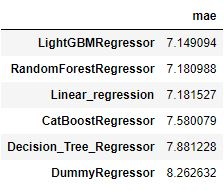

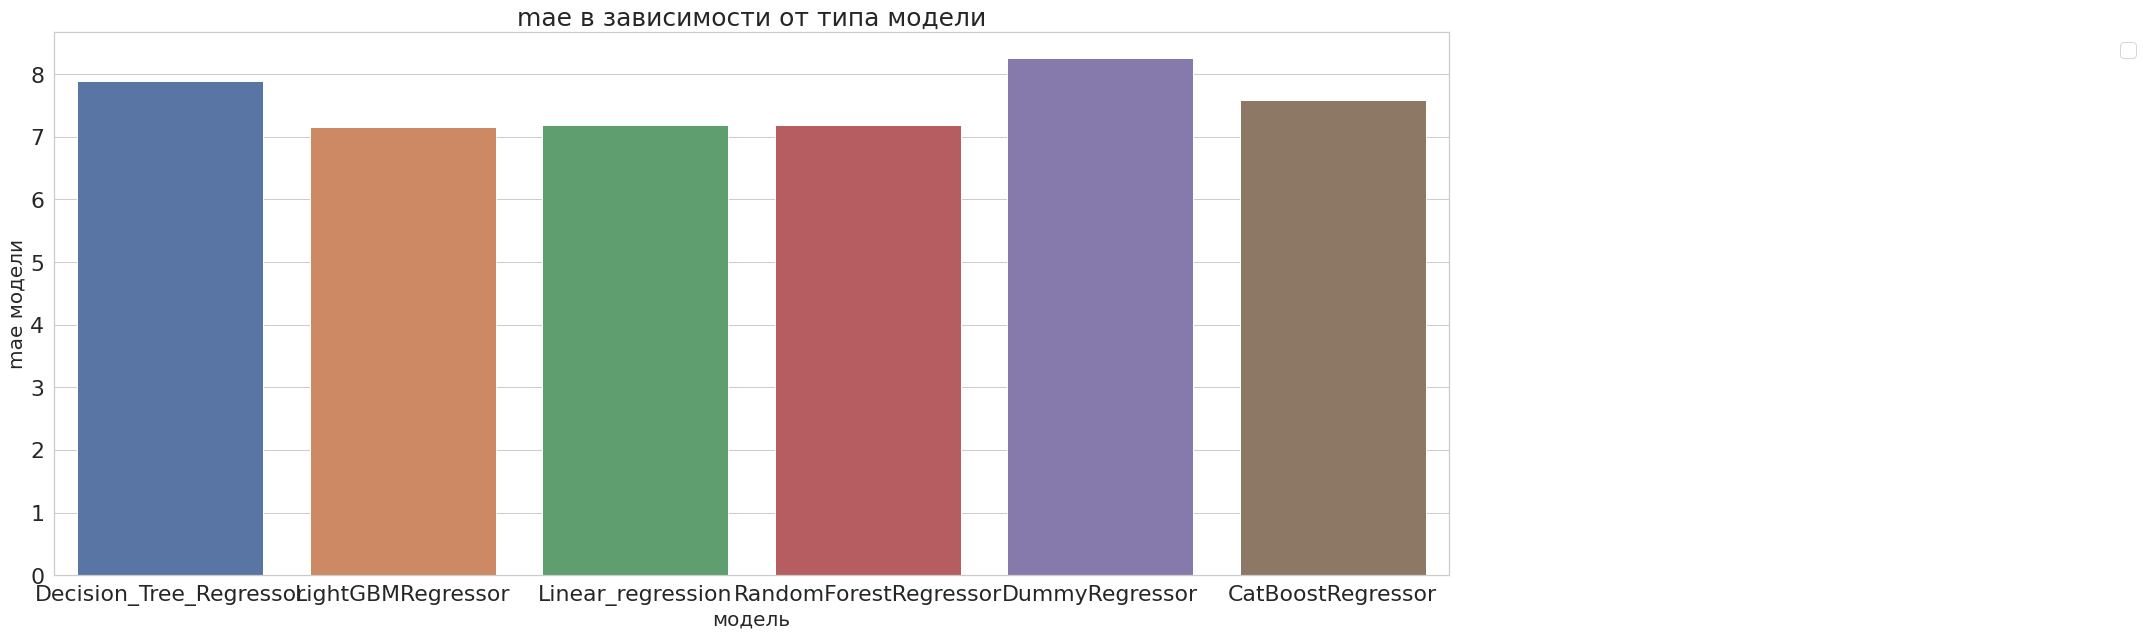

на тестовой выборке итоговая модель дала результат МАЕ = 6.5898

### Перечисление использовавшихся признаков и описание их предобработки

В итговой модели использованы 10 признаков:
    
- gas - данные по газу, удаление столбца вело к ухудшению метрики - брал сразу из таблицы по газу

Следующие три признака извлечены из одной таблицы

- active_power - активная мощность - брал среднее группируя по ключу
- reactive_power - реактивная мощность - брал среднее группируя по ключу
- heat_time_seconds - длительность нагрева - считал исходя из разницы времени окончания и начала нагрева, потом брал среднее группируя по ключу

видна их достаточно сильная корреляция 

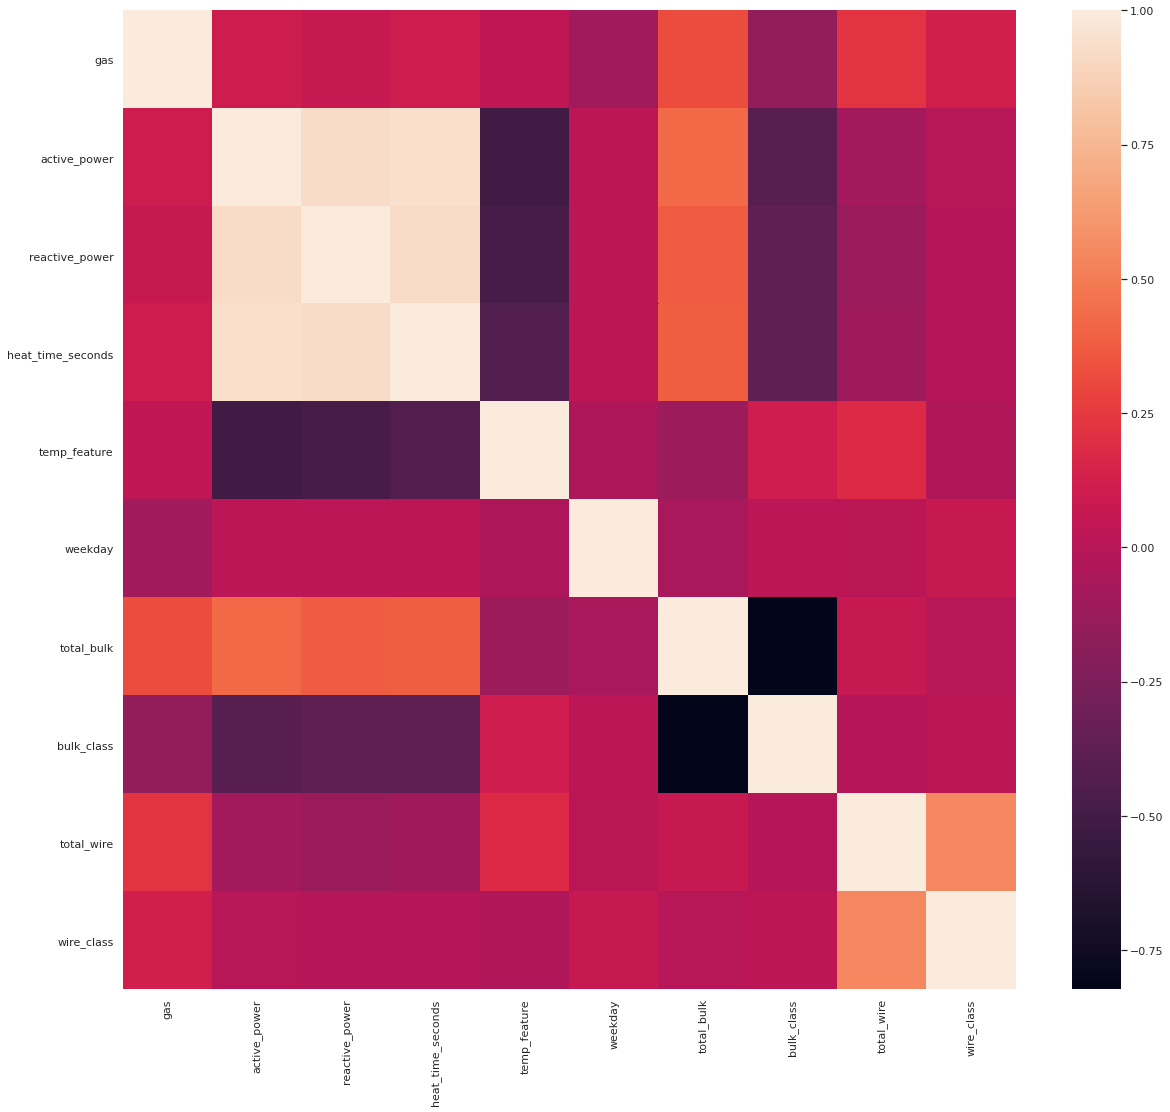

исходя из того, что мультиколлинеарность может выести к ухудшению результатов пробовал удалять некоторые из трех признаков выше, но реузльтат вел к ухудшению - поэтому оставил все                        

- temp_feature - начальная температура (заметна некоторая отрицательная корреляция с признаками из таблицы по нагреву), удаление столбца вело к ухудшению метрики - брал первое значение по ключу из таблицы по температуре

- weekday - день недели я решил выделить потому что мне показалось, что в диаграммах размаха по температуре и по мощностях видна некоторая периодичность (не факт что к неделе привязанная, но решил попробовать) - не думаю, что признак очень полезен, но его удаление вело к ухудшению метрики

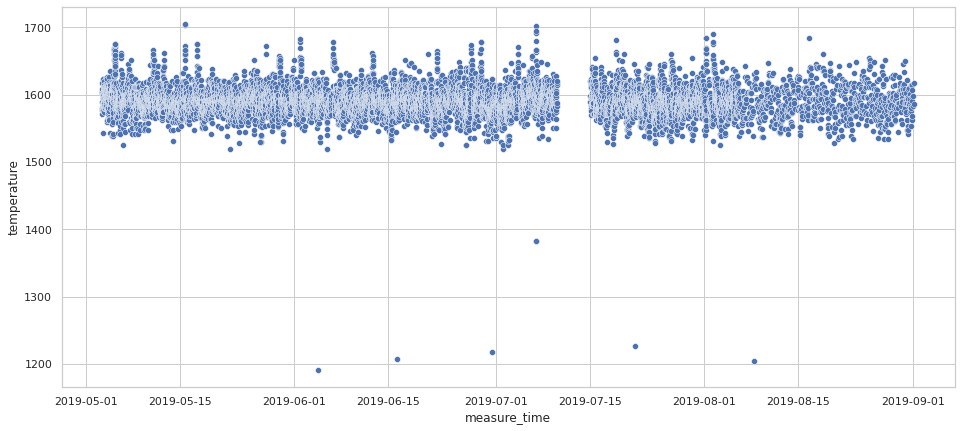

- total_bulk - общее число сыпучих веществ (сумма всех столбцов по ключу), удаление столбца вело к ухудшению метрики

- bulk_class - класс получаемый в ходе уменьшения размерности таблицы сыпучих веществ - исходно было не совсем ясно как эту таблицу еще применить, но как раз на последнем спринте поднималась тема k-means - решил попробовать так - удаление столбца вело к ухудшению метрики

- total_wire - общее число проволок (сумма всех столбцов по ключу), удаление столбца вело к ухудшению метрики

- wire_class - класс получаемый в ходе уменьшения размерности таблицы проволок - исходно было не совсем ясно как эту таблицу еще применить, но как раз на последнем спринте поднималась тема k-means - решил попробовать так - удаление столбца вело к ухудшению метрики

на heatmap видна сильная корреляция класса сыпучих и их суммы, то же для проволок (со знаком - но знак здесь не важен) - думаю, что нормальный результат по крайней мере видно, что удаление тех или иных столбцов результат ухудшало так что предполагаю, что мультиколлинеарность здесь не мешала

После применения LightGBM выводил график с важностью признаков, финальный ниже. У меня были попытки исходя из графика удалять наименее важные, но это вело к ухудшению.

По ходу работы пытался сделать признаки из часа дня, дня/ночи, будней/выходных - но с ними результат становился хуже - поэтому здесь их нет

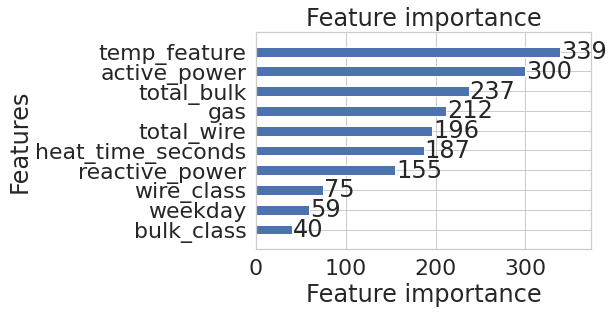